# Lecture 1 - Generalized Linear Models: Link Functions and Count Regression

## A Brief Digression on Textboxes

Throughout these lecture notes, you could find textboxes that highlight the following:

```{admonition} Definition
:class: tip
A formal statistical definition of any given concept with a key role in the lecture's main topic.
```

```{important} 
An idea of crucial relevance for the lecture's main topic. Mapping this idea in your learning process will help in the course's lab assignments and quizzes.
```

```{admonition} Note
:class: note
An idea that might be slightly out of the main scope of the lecture but with particular relevance for proper statistical practice in a Data Science context.
```

Moreover, you might find some sections marked as "**Optional**." This labelling indicates we will not review that specific material in this course due to time constraints. Still, you might encounter these regression topics in the practice of Data Science. Thus, we provide their corresponding foundations in these notes.

## Today's Learning Goals

By the end of this lecture, you should be able to:

- Explain the Data Science workflow in Regression Analysis.
- Recall the basics of Ordinary Least-squares (OLS) regression.
- Identify cases where OLS regression is not suitable.
- Distinguish what makes a regression model "*linear*."
- Explain the concept of generalized linear models (GLMs).
- Explore the concept of the link function.
- Outline the modelling framework of count regression.
- Fit and interpret count regression.
- Use count regression for prediction.
- Explain and test overdispersion on count-type data.

## Loading Libraries

In [1]:
options(repr.matrix.max.rows = 6)
source("../scripts/support_functions.R")
library(tidyverse)
library(mlbench)
library(AER)
library(cowplot)
library(broom)
library(performance)
library(qqplotr)
library(glmbb)

── Attaching core tidyverse packages ─────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ───────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: car

Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode


The following object is masked from ‘package:purrr’:

    some


Loading required package: lmtest

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required 

(DS-workflow-preamble)=
## 1. A Preamble on our Data Science Workflow

This course continues on the regression foundations you saw in [**DSCI 561**](https://github.com/UBC-MDS/DSCI_561_regr-1) (Regression I). That said, we will go beyond OLS regression and explore further regression techniques. In practice, these techniques have been developed in the statistical literature to address practical cases where the OLS modelling framework and assumptions are not suitable anymore. Thus, throughout this block, we will cover (at least) one new regression model per lecture.

All in all, you might notice that the lecture pace in this course will be faster in terms of the amount of regression models we aim to cover. Then, to have a homogeneous way to approach each one of these models, we have structured this regression course in three big pillars:

1. The use of an ordered **Data Science workflow**,
2. choosing the proper workflow flavour according to either an **inferential** or **predictive** paradigm, and
2. the correct use of an **appropriate regression model** based on the response of interest.

Each one of these three pillars is heavily connected since a general Data Science workflow is applied in each one of these regression models, which aims to help in our learning (i.e., we would be able to know what exact stage to expect in our data analysis regardless of the regression model we are being exposed to). 

Therefore, a crucial aspect of the practice of Regression Analysis is the need for this systematic Data Science workflow that will allow us to solve our respective inquiries in a transparent and reproducible way. {numref}`data-science-workflow` shows this workflow which has the following general stages:

1. **Study design**.
2. **Data collection and wrangling**.
3. **Exploratory data analysis**.
4. **Data modelling**.
5. **Estimation**.
6. **Results**.
7. **Storytelling**.

````{div} full-width
```{figure} ../img/data-science-workflow.png
:height: 1400px
:name: data-science-workflow
Data Science workflow for **inferential** and **predictive** inquiries in Regression Analysis.
```
````

```{important} 
Note the workflow in {numref}`data-science-workflow` has certain checkpoints in which we either choose **inference** and **prediction** according to the data inquiries defined in the **Study Design**.

Now, suppose we do not follow a predefined workflow in practice. In that case, we might be at stake in incorrectly addressing our inquiries, translating into meaningless results outside the context of the problem we aim to solve. This is why the formation of a Data Scientist must stress this workflow from the very introductory learning stages.
```

Subsequent subsections will define the seven stages and their relationship with previous (or future!) MDS courses.

### 1.1. Study Design

The first stage of this workflow is heavily related to the **main statistical inquiries** we aim to address throughout the whole process. As a Data Scientist, it is your task to primarily translate these inquiries from the stakeholders of the problem as **inferential** or **predictive**. Roughly speaking, this primary classification can be explained as follows:

- **Inferential.** The main objective is to untangle relationships of **association** or **causation** between the **regressors** (i.e., explanatory variables) and the corresponding **response** in the context of the problem of interest. Firstly, we would assess whether there is a statistical relationship between them. Then, if significant, we would quantify by how much.

- **Predictive.** The main objective is to deliver response predictions on further observations of regressors, having estimated a given model via a current training dataset. Unlike inferential inquiries, assessing a statistically significant association or causation between our variables of interest is not a primary objective but **accurate predictions**. This is one of the fundamental paradigms of **Machine Learning**.

``` {figure} ../img/panda.png
:height: 350px
:name: panda
The Questioning Panda comes back.
```

```{important} 
Throughout the lecture notes and lab assignments, this stage will be called "**Main Statistical Inquiries**."
```

### 1.2. Data Collection and Wrangling

Once we have defined our main statistical inquiries, it is time to collect our data. It is essential to be careful about the way we collect this data since it might have a particular impact on the quality of our statistical practice:
?
- Regarding inferential inquiries, recall the topics from `lecture1` in [**DSCI 552**](https://github.com/UBC-MDS/DSCI_552_stat-inf-1/blob/master/lectures/01_lecture-sampling-through-simulation.ipynb) (Statistical Inference and Computation I). We are approaching **populations** or **systems** of interest governed by **unknown and fixed parameters**. Thus, via sampled data, we aim to **estimate** these parameters. This is why **a proper sampling method** on this population or system of interest is critical to obtaining representative data for **appropriate hypothesis testing**.

```{admonition} Note
:class: note
This stage is coloured in gray in {numref}`data-science-workflow`, unlike the other ones coloured in yellow. This is because sampling topics are out of the scope of this course and MDS in general. Nevertheless, we still need to stress that a  proper sampling method is also key in inferential inquiries to assess association and/or causation between the regressors and your response of interest. That said, depending on the context of the problem, we could apply either one of the following methods of sampling:

- **Simple random sampling**.
- **Systematic sampling**.
- **Stratified sampling**.
- **Clustered sampling**.
- Etc.

As in the case of Regression Analysis, statistical sampling is a vast field, and we could spend a whole course on it. If you are more interested in these topics, [*Sampling: design and analysis*](https://webcat.library.ubc.ca/vwebv/holdingsInfo?bibId=2206157) by Lohr offers great foundations.
```

- In practice, regarding predictive inquiries, we would likely have to deal with databases given that our trained models will not be used to make inference and parameter interpretations.

```{important} 
You have learned key technical skills to manage databases such as in [**DSCI 513**](https://github.com/UBC-MDS/DSCI_513_database-data-retr) (Databases and Data Retrieval). That said, our main focus in this course will be more centred on data modelling rather than database management. Still, throughout the lecture notes and lab assignments, we will sometimes execute some straightforward "**Data Wrangling**."
```

### 1.3. Exploratory Data Analysis

Before delivering proper data modelling and after an appropriate collection, it is essential to depict the relationships between your variables of interest in the corresponding collected **training data**. This is why the third stage corresponds to the exploratory data analysis (EDA). Furthermore, even before we start coding our corresponding plots using our wrangled data, we need to execute a **variable classification** carefully:

- Under the context of Regression Analysis, what is our response of interest $Y$? Is it discrete or continuous?
    1. If it is discrete; is it binary, count or categorical?
    2. If it is continuous, is it bounded or unbounded?
- Again, under the context of Regression Analysis, what are our $k$ regressors $X_1, \dots, X_k$?
    1. If a given regressor is discrete; is it binary, count or categorical?
    2. If a given regressor is continuous, is it bounded or unbounded?

The above classification will give us the necessary insights to choose the most appropriate modelling approach for our response of interest. Moreover, if our inquiries are inferential, this classification will provide a solid idea of the interpretation for each estimated parameter corresponding to these $k$ regressors.

```{important} 
You have learned vital technical skills for plotting such as in [**DSCI 531**](https://github.com/UBC-MDS/DSCI_531_viz-1) (Data Visualization I). Hence, we can proceed with our plot coding once we have executed a correct variable classification. Throughout the lecture notes and lab assignments, you must select the suitable set of EDA plots based on this classification along with key **descriptive summary statistics**.
```

### 1.4. Data Modelling

[**DSCI 551**](https://ubc-mds.github.io/DSCI_551_stat-prob-dsci/README.html) (Descriptive Statistics and Probability for Data Science) touched upon essential foundations in probability related to random variables and distributions. That said, we will follow three important steps:

1. Recall that we stressed the fact of proper choice of a random variable, depending on the context of our data modelling problem (i.e., the [**distribution mind map**](https://ubc-mds.github.io/DSCI_551_stat-prob-dsci/notes/appendix-dist-cheatsheet.html)). Hence, we will use this practice to model our response of interest in Regression Analysis. Moreover, we will define whether we aim to model its conditional expected value given our $k$ regressors or some other statistic (e.g., a conditioned median or some other quantile!). All these facts will allow us to choose **the right regression model**.

2. Given our chosen regression model, we must define what **modelling parameters** we aim to estimate via our training data (e.g., intercept and coefficients along with some response variance components such as $\sigma^2$ in OLS).

3. Finally, we have to set up our **mathematical modelling equation**, which will allow us to explain in plain words how the regressors are related to the response once we estimate the modelling parameters. This fact will be significantly emphasized throughout the lecture and lab assignments as "**Data Modelling Framework**."

```{important} 
The above steps (1) and (2) can be viewed as having a toolbox of possible models we could use. Take the mind map depicted in {numref}`reg-mindmap-1` as a starting point with the OLS model you saw in **DSCI 561**. Here is how we can go over the mind map: 

> *In **Regression Analysis**, we can model an **unbounded continuous response** in terms of their **global conditioned mean** using **Ordinary Least-Squares (OLS)** for **inference** or **prediction**.*

Note we added the **global** characteristic to the below mind map since we will also cover local regression models during this block. Furthermore, this mind map will expand as we learn new regression models throughout subsequent lectures.
```

```{figure} ../img/reg-mindmap-1.png
:height: 450px
:name: reg-mindmap-1
Initial regression modelling mind map.
```

### 1.5. Estimation

In most of the models we will learn in this block, in conjunction with the probabilistic topics from **DSCI 551**, we will rely on [**maximum likelihood estimation (MLE)**](https://ubc-mds.github.io/DSCI_551_stat-prob-dsci/notes/07_lecture-maximum-likelihood-estimation.html) to estimate the modelling parameters we defined in step (2) from the **Data Modelling** stage.

```{important} 
In plain words, MLE uses the training data's joint probability distribution, which contains the modelling parameters, to find the numerical values of these parameters that maximize the likelihood function (**which is mathematically equivalent to the joint probability distribution of the training data**).

Even though MLE will be the estimation method for most of the regression models in this block, some other models will rely on loss functions analogous to the estimation method of OLS. Finally, it is important to clarify that our estimation and inferential paradigms will be **frequentist** in this course.
```

```{admonition} Note
:class: note
`R` will be the programming language for this course. Regarding modelling estimation, we will use standalone fitting functions (with their specific syntax) across different packages. Nevertheless, these functions can also be found in `Python,` which is outside the scope of our lectures. The `Python` package `statsmodels` offers [**estimation tools**](https://www.statsmodels.org/stable/user-guide.html) for most models we will review in this block.
```

### 1.6. Results

It is time to use our modelling estimates to solve our main statistical inquiries. As we previously discussed, the way we proceed in this stage will depend on whether our inquiries are inferential or predictive:

1. **Inferential.** Since our training set is assumed to be a random sample from our population or system of interest, we will conduct the corresponding hypothesis testing (e.g., the [**$t$-test**](https://pages.github.ubc.ca/mds-2024-25/DSCI_561_regr-1_students/lectures/03_slr-inf.html#hypothesis-tests-for-the-regression-coefficients) in OLS) on our modelling estimates for the regression coefficients (along with the yielded standard errors from the corresponding estimation method such as MLE for many models to be reviewed in this block). These tests will allow us to deliver a significance conclusion on whether there is an association/causation between the regressors and the corresponding response of interest. Once we have determined a statistical significance, we can deliver the following:

    * **Point estimate.** It is the estimate of the regression coefficient for the $j$th regressor (i.e., $\hat{\beta}_j$) along with its corresponding interpretation. This is why it is important to fully explain, in plain words, our **mathematical modelling equation** from the **Data Modelling** stage.
    * **Interval estimate.** This corresponds to the **confidence interval** we will compute using *$\hat{\beta}_j$* and its standard error. Recall that we always have to provide an interval estimate in our inferential conclusions since it measures the uncertainty of our point estimates.

2. **Predictive.** Once we have estimated our regression model, we can obtain predictions on a further test set. Moreover, across courses such as [**DSCI 571**](https://github.com/UBC-MDS/DSCI_571_sup-learn-1) (Supervised Learning I) and [**DSCI 573**](https://github.com/UBC-MDS/DSCI_573_feat-model-select) (Feature and Model Selection), you have seen metrics and techniques to assess prediction accuracy on a given estimated model.

```{important} 
Mostly for predictive inquiries, and sometimes for inference, this stage could include applying **model selection techniques** (as seen in [**DSCI 561**](https://github.com/UBC-MDS/DSCI_561_regr-1)). These techniques rely on **goodness of fit** and involve using a specific type of regression framework and then, estimating a set of candidate models using the same response but different subsets of regressors coming from our training data. **The final goal of model selection will be choosing the best model fitting.**

That said, we will cover **maximum likelihood-based model selection techniques** in this block. Moreover, note that {numref}`data-science-workflow` does not explicitly mention model selection techniques. However, you could implement them right after estimating your modelling parameters (i.e., after the **Estimation** stage). Finally, this practice would make the workflow iterative between the **Estimation** and **Results** stages.
```

```{admonition} Note
:class: note
As a side note, at the end of this stage, we can also apply **model diagnostics** analogous to **the ones for OLS** but for other types of regression models. Nevertheless, given the time constraints, these tools will not be covered during lecture time. Still, when possible, we will provide **optional** notes outlining them.
```

### 1.7. Storytelling

The final stage of this workflow is what we call **Storytelling**. This stage involves communicating our inferential or predictive findings to a specific audience of stakeholders (either technical or non-technical). This is why a course such as **DSCI 542** (Communication and Argumentation) is crucial in MDS.

```{important} 
We will sometimes dig into this stage in our warmup exercises during the lab sessions. Moreover, **DSCI 554** (Experimentation and Causal Inference) will fully explore this stage.
```

## 2. Review of Ordinary Least-squares Regression

Let us quickly review the OLS model before proceeding to alternative regression approaches. 

In **DSCI 561**, you learned comprehensive material about OLS regression. You might wonder:

> Why are we using the term "**ordinary**"? 

The term "**ordinary**" refers to a linear regression model with a **response** (also known as **endogenous variable**) of **continuous nature**. From **DSCI 551**, recall that a continuous variable can take on an infinite number of real values in a given range. This response is subject to **regressors** (also known as **exogenous variables**, **explanatory variables**, **features**, or **predictors**). Note that the regressors can be of a continuous or discrete nature. When the regressors are **discrete** and **factor-type** (i.e., with different categories), they could be: 

- **Nominal.** In this factor-type variable, we have categories that do not follow any specific order. For example, a clinical trial with a factor of three treatments: *placebo*, *treatment A*, and *treatment B*.
- **Ordinal.** The categories, in this case, follow a specific hierarchical order. A typical example is the *Likert scale* of survey items: *strongly disagree*, *disagree*, *neutral*, *agree*, and *strongly agree*.

```{important} 
The OLS case is a classic starting learning topic in Regression Analysis. In fact, we might call this model "*classical linear regression*."
```

### 2.1. Data Modelling Framework

Let us dig into the general **Data Modelling** stage in OLS regression. Conceptually, the OLS regression model can be expressed as:

$$
\mbox{Response} = \mbox{Systematic Component} + \mbox{Random Component}.
$$ (eq-conceptual_model)

- The **systematic component** represents the mean of the response **which is conditioned on the regressor values**. 
- The **random component** measures the extent to which the observed value of the response might deviate from its mean and is viewed as **random noise**.

For the $i$th observation in our **random sample** or **training data** ($i = 1, \dots, n$), the conceptual model {eq}`eq-conceptual_model` is mathematically represented as:

$$
\underbrace{Y_i}_\text{Response}  = \underbrace{\beta_0 + \beta_1 g_1(X_{i, 1}) + \ldots + \beta_k g_k(X_{i,k})}_\text{Systematic Component} + \underbrace{\varepsilon_i.}_\text{Random Component}
$$ (eq-OLS_model)

Note the following:

- The response $Y_i$ is equal to the sum of $k + 2$ terms on the right-hand side.
- The systematic component is the sum of:
    - An **unknown intercept** $\beta_0$ and
    - $k$ **regressor functions** $g_j(X_{i,j})$ multiplied by their respective **unknown regression coefficient** $\beta_j$ ($j = 1, \dots, k$).
- $\varepsilon_i$ is the **random noise**.

#### 2.1.1. Modelling Assumptions

The model in {eq}`eq-OLS_model` above for $Y_i$ is more detailed as follows:

- The response $Y_i$ depends on the **linear combination** of the functions $g_j(\cdot)$ of $k$ regressors $X_{i, j}$ of different types (continuous and discrete). 

- Each function $g_j(X_{i,j})$ has an associated regression coefficient. These parameters $\beta_{1}, \dots, \beta_{k}$ represent how much the response is expected to increase or decrease when the function $g_j(X_{i,j})$ changes by one unit of the $j$th regressor. An additional parameter, $\beta_0$, represents the mean of the response when all the $k$ functions $g_j(X_{i,j})$ are equal to zero. All these elements represent the systematic component of the model.

- The term $\varepsilon_i$ is an unobserved random variable and represents the random component. These variables are **usually** assumed to be **normally distributed** with **mean of zero** and a **common variance** $\sigma^2$ (i.e., **homoscedasticity**). Moreover, all $\varepsilon_i$s are assumed to be **independent**.

````{admonition} Definition of Random Component Assumptions in OLS
:class: tip

```{math}
\begin{gather*}
\mathbb{E}(\varepsilon_i) = 0 \\
\text{Var}(\varepsilon_i) = \sigma^2 \\
\varepsilon_i \sim \mathcal{N}(0, \sigma^2) \\
\varepsilon_i \perp \!\!\! \perp \varepsilon_k \; \; \; \; \text{for} \; i \neq k  \; \; \; \; \text{(independence)}.
\end{gather*}
```
````

- Hence, **each $Y_i$ is also assumed to be independent and normally distributed**:

$$
Y_i \mid X_{i, j} \sim \mathcal{N} \big( \beta_0 + \beta_1 g_1(X_{i, 1}) + \ldots + \beta_k g_k(X_{i,k}), \sigma^2 \big).
$$ (Y-OLS_model-normal)

#### 2.1.2. Categorical Regressors

If the $j$th explanatory variable of interest (or regressor) is continuous, its observed value is expressed as a single $x_{i,j}$ for the $i$th observation. 

Suppose a explanatory variable of interest is nominal. In that case, we will need to use a dummy variable to identify the category to which each observation belongs. For instance, if a discussed categorical explanatory variable of interest has $u$ categories or levels, we could define $u - 1$ dummy variables as shown in the coding scheme in {numref}`dummy-var`. Note that **Level 1** is taken as the baseline (reference) level: if the $i$th observation belongs to **Level 1** then all the dummy variables $x_{i,1}, \cdots, x_{i,(u - 1)}$ take on the value $0$. The choice of baseline has an impact on the interpretation of the regression coefficients. The baseline is related to the role of the intercept $\beta_0$.

```{list-table} Dummy variables in a nominal regressor with $u$ levels.
:header-rows: 1
:name: dummy-var

* - **Level**
  - $x_{i, 1}$
  - $x_{i, 2}$
  - $\cdots$
  - $x_{i, (u - 1)}$
* - $1$
  - $0$
  - $0$
  - $\cdots$
  - $0$
* - $2$
  - $1$
  - $0$
  - $\cdots$
  - $0$
* - $\vdots$
  - $\vdots$
  - $\vdots$
  - $\ddots$
  - $\vdots$
* - $m$
  - $0$
  - $0$
  - $\cdots$
  - $1$
```

### 2.2. Can We Apply Linear Regression Here?

Having briefly discussed the components of the OLS model in {eq}`eq-OLS_model`, let us explore three 2-$d$ examples made with simulated data. Thus, we will start with some in-class questions via [**iClicker**](https://student.iclicker.com/).

```{exercise}
:label: lecture1-q1

In what of the below example(s) can we apply linear regression?

**A.** Examples 1 and 2.

**B.** Example 1.

**C.** Examples 1 and 3.

**D.** Examples 1, 2, and 3.
```

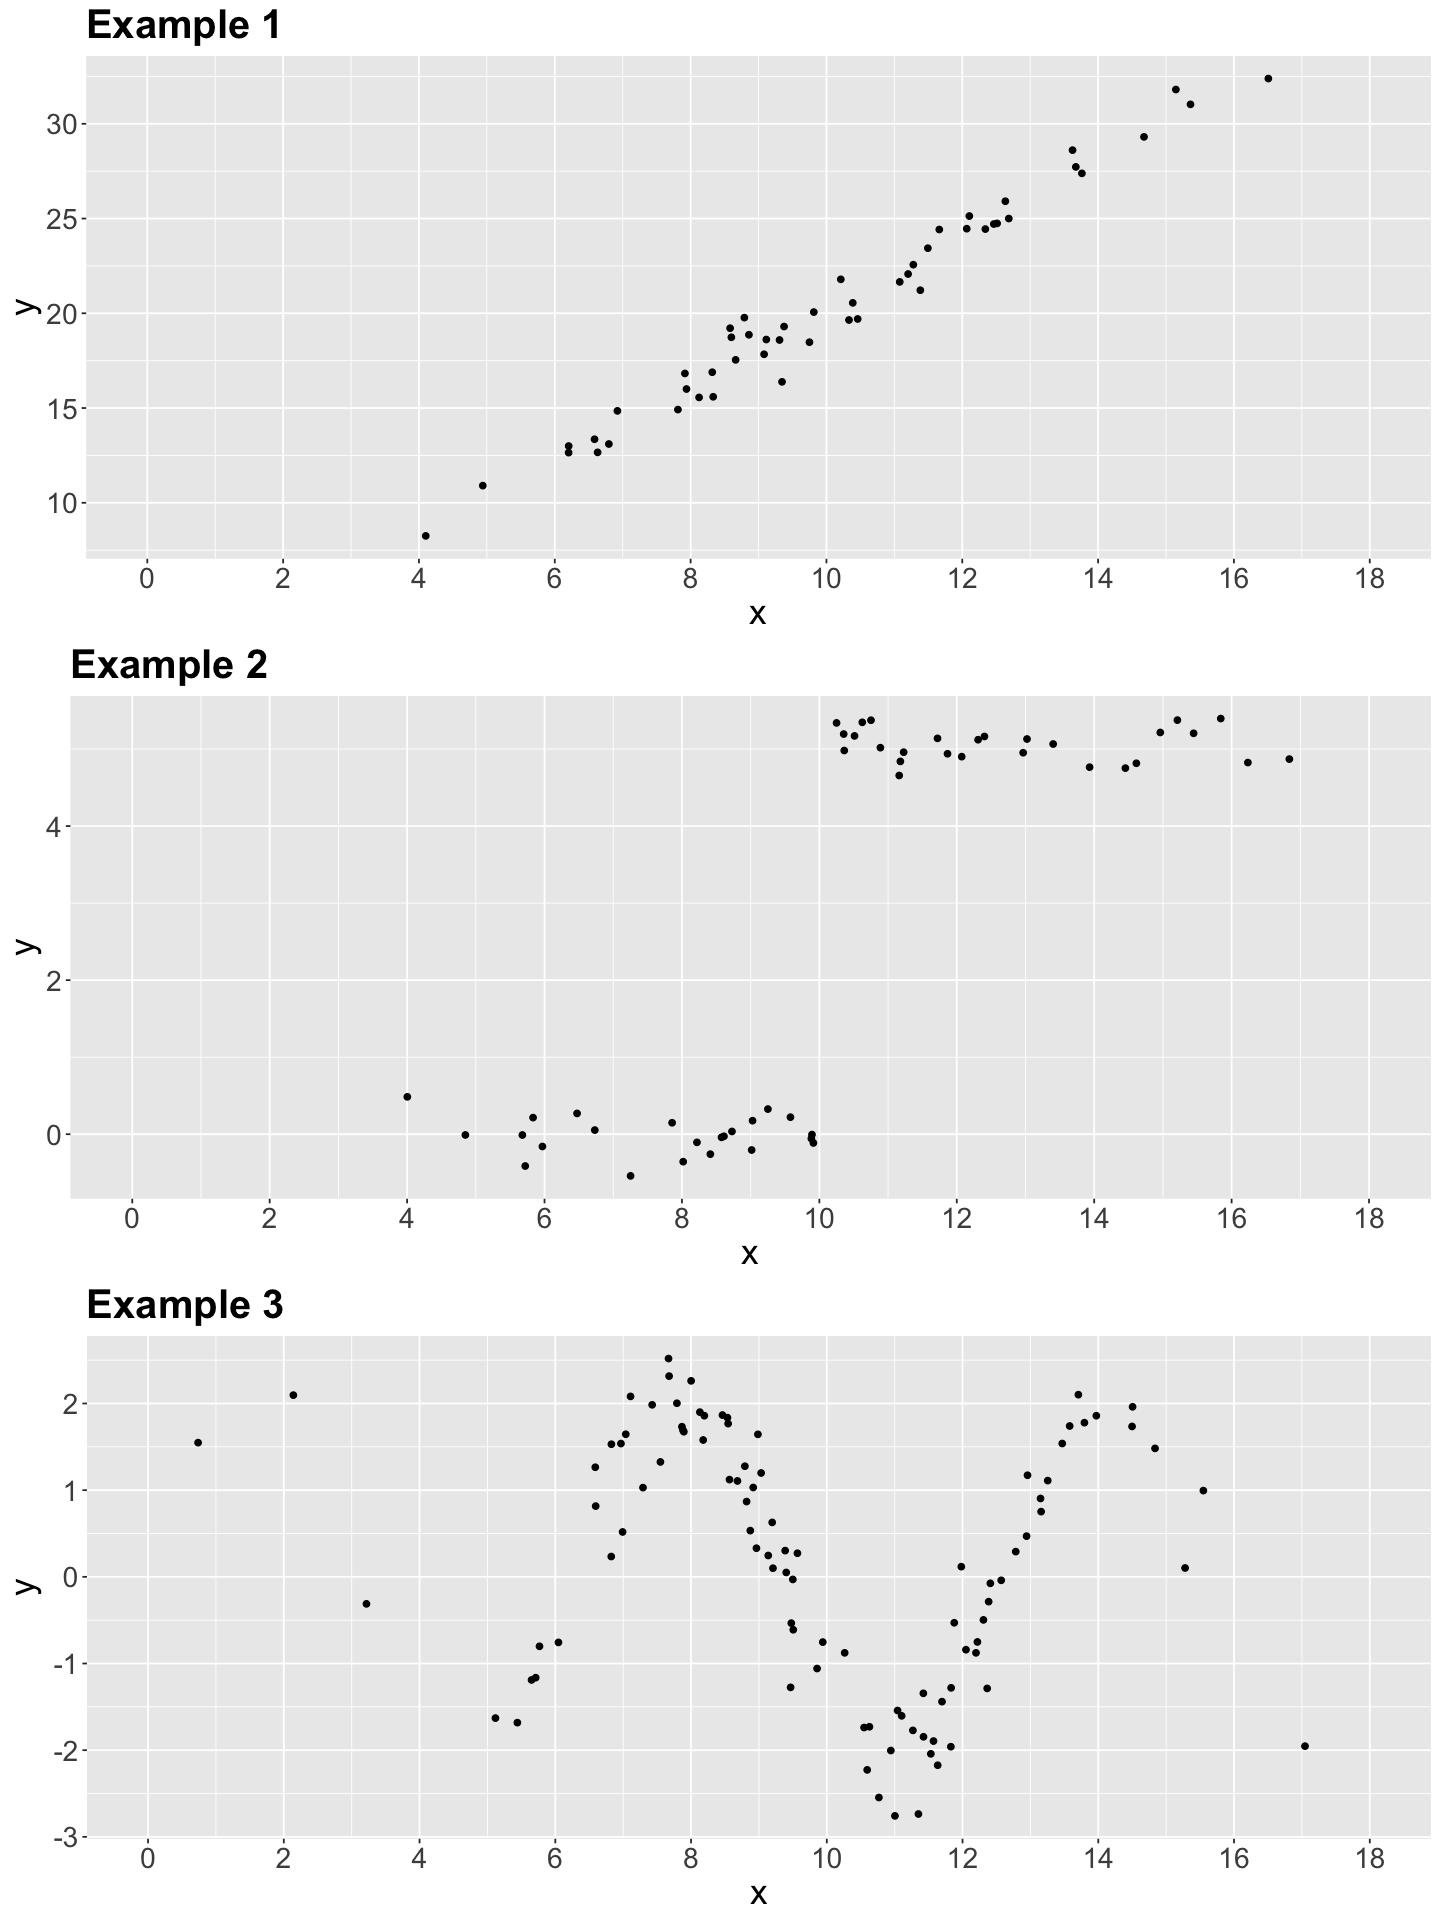

In [2]:
options(repr.plot.height = 16, repr.plot.width = 12)
plot_grid(example_1(), example_2(), example_3(), nrow = 3)

### 2.3. What makes a regression model "*linear*"?

Let us retake the **Example 3** from our previous activity.

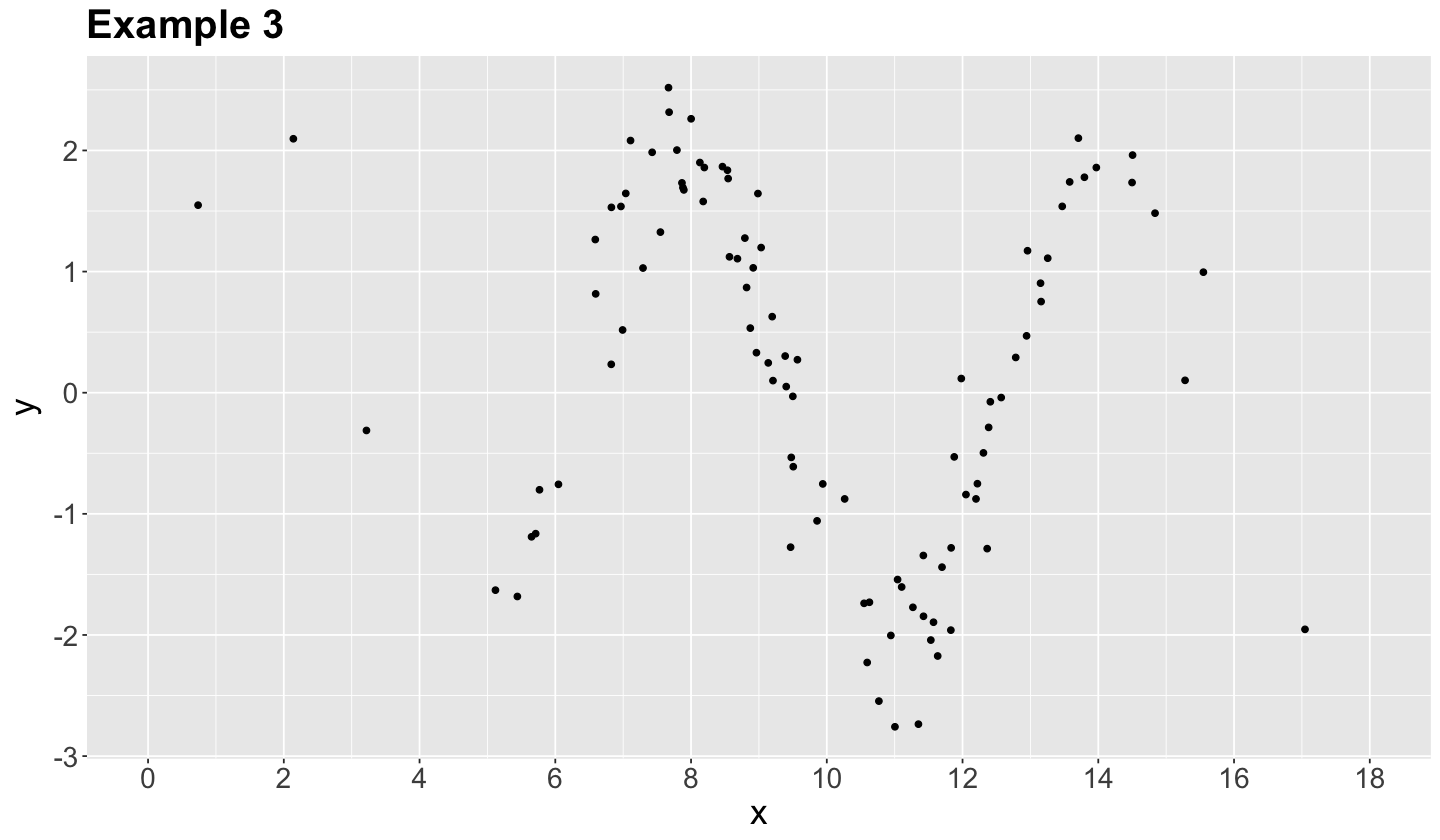

In [3]:
options(repr.plot.height = 7, repr.plot.width = 12)
example_3()

It turns out that each synthetic data point was generated from a sinusoidal curve plus some normally distributed random noise:

```{math}
\begin{align*}
Y_i &= \beta_0 + \beta_1 g(X_i) + \varepsilon_i \\
&= \beta_0 + \beta_1 \sin(X_i) + \varepsilon_i.
\end{align*}
```

As we can see, this example can be modelled as an OLS model **if we transform each $x_i$ in the training set as $\sin(x_i)$**.

Now, let us generalize all these previouse ideas. When a linear regression model has more than one regressor, then we call it **multiple linear regression model**.

````{admonition} Definition of Linearity in Regression Models
:class: tip

The classical OLS model, from **DSCI 561**, implicates the identity function $g_j(X_{i, j}) = X_{i, j}$ in equation 
{eq}`eq-OLS_model`. This leads to:

```{math}
\begin{align*}
Y_i &= \beta_0 + \beta_1 g_1(X_{i, 1}) + \ldots + \beta_k g_k(X_{i,k}) + \varepsilon_i \\
&= \beta_0 + \beta_1 X_{i,1} + \ldots + \beta_k X_{i,k} + \varepsilon_i.
\end{align*}
```

Note the model is "linear" on the parameters (i.e., regression terms), not the regressors.
````

Finally, suppose we have a training dataset of $n$ observations; i.e., for $i = 1, \dots, n$. Then all the $X_{i, j}$ become observed values $x_{i, j}$ (note the lowercase), leading to the following conditional expected value of the OLS model above as:

$$
\mathbb{E}(Y_i \mid X_{i,j} = x_{i,j}) = \beta_0 + \beta_1 x_{i,1} + \ldots + \beta_k x_{i,k} \; \; \; \; \text{since} \; \; \; \; \mathbb{E}(\varepsilon_i) = 0.
$$

We can see that the regression coefficients' interpretation is targeted to explain each regressor's numerical **association** (**or effect if we are conducting an experiment!**) on the mean of the response, **if we fulfill the assumptions on the random component** $\varepsilon_i$.

### 2.4. Estimation

The next matter to address is how to estimate our OLS parameters since these are unknown. In order to fit a linear regression model for a given training dataset of $n$ observations, we have to estimate the $k + 2$ parameters $\beta_0, \beta_1, \dots, \beta_k, \sigma^2$ by **minimizing the sum of squared residuals** (i.e., **least-squares estimation**) or **maximizing the likelihood function of the sample**. 

The **likelihood function** is the **joint probability density function (PDF)** of the observed data as a function of the unknown parameters $\beta_0, \beta_1, \dots, \beta_k, \sigma^2$ we are willing to estimate. A particular distribution is assumed for the individual observations. MLE aims to find the values of those parameters for which the observed data is more likely. The likelihood function for the multiple linear regression model is described as follows:

- We assume a random sample of $n$ elements. Thus, the Normal $Y_i$s are independent as in {eq}`Y-OLS_model-normal`, which allows us to obtain the sample's joint PDF. 

- The joint PDF is obtained by multiplying the standalone $n$ Normal PDFs altogether. This joint PDF is mathematically equal to the likelihood function of the observed data.

- The MLE method takes the first partial derivatives of the **log-likelihood function** with respect to $\beta_0, \beta_1, \dots, \beta_k, \sigma^2$. Then, we set these derivatives equal to zero and isolate the corresponding terms. This procedure yields the maximum likelihood estimates.

- The case of simple linear regression (as in $\beta_0$, $\beta_1$, and $\sigma^2$) can be handled in scalar notation. However, in the presence of a considerable number of coefficients, it is more efficient to work with the model in matrix notation. Then, matrix calculus comes into play.

```{important}
Now, we might wonder: 

> How is MLE related to OLS?

This is the point were the assumptions on the error component $\varepsilon_i$ have a key role in MLE. If we make the corresponding mathematical derivations, **it turns out that maximizing the log-likelihood function in MLE is equivalent to minimizing the sum of squared residuals in OLS**.
```

### 2.5. Inference

As we discussed in {ref}`DS-workflow-preamble`, the estimated model can be used for two purposes: **inference** and **prediction**.

In terms of inference, we use the fitted model to identify the relationship between the response and regressors. We will need the $j$th estimated regression coefficient $\hat{\beta}_j$ and its corresponding variability which is reflected in the **standard error** of the estimate, $\mbox{se} \left( \hat{\beta}_j \right)$. To determine the statistical significance of $\hat{\beta}_j$, we use the **test statistic**

$$t_j = \frac{\hat{\beta}_j}{\mbox{se} \left( \hat{\beta}_j \right)}$$


to test the hypotheses

```{math}
\begin{gather*}
H_0: \beta_j = 0 \\
H_a: \beta_j \neq 0.
\end{gather*}
```

A statistic like $t_j$ is referred to as a $t$-value. It has a $t$-distribution **under the null hypothesis** $H_0$ with $n - k - 1$ degrees of freedom.

We can obtain the corresponding $p$-values for each $\beta_j$ associated to the $t$-values under the null hypothesis $H_0$. **The smaller the $p$-value, the stronger the evidence against the null hypothesis $H_0$ in our sample**. Hence, small $p$-values (less than the significance level $\alpha$) indicate that the data provides evidence in favour of association (or **causation** if that is the case) between the response variable and the $j$th regressor. 

Similarly, given a specified $(1-\alpha) \times 100\%$ level of confidence, we can construct **confidence intervals** for the corresponding true value of $\beta_j$:

$$
\hat{\beta}_j \pm t_{\alpha/2, n - k - 1}\mbox{se} \left( \hat{\beta}_j \right),
$$

where $t_{\alpha/2, n - k - 1}$ is the upper $\alpha/2$ quantile of the $t$-distribution with $n - k - 1$ degrees of freedom.

### 2.6. Violations of Assumptions

Recall the multiple linear regression model is defined as

$$
Y_i = \beta_0 + \beta_1 X_{i,1} + \ldots + \beta_k X_{i,k} + \varepsilon_i,
$$

where $\varepsilon_i$ (random component) is subject to these assumptions:

```{math}
:label: OLS-assumptions
\begin{gather}
\mathbb{E}(\varepsilon_i) = 0 \\
\text{Var}(\varepsilon_i) = \sigma^2 \\
\varepsilon_i \sim \mathcal{N}(0, \sigma^2) \\
\varepsilon_i \perp \!\!\! \perp \varepsilon_k \; \; \; \; \text{for} \; i \neq k  \; \; \; \; \text{(independence)}.
\end{gather}
```

Now, **what would happen if the assumptions in {eq}`OLS-assumptions` are violated?** The below **diagnostic plots**  belong to **simulated data** whose OLS model violates the **normality assumption**.

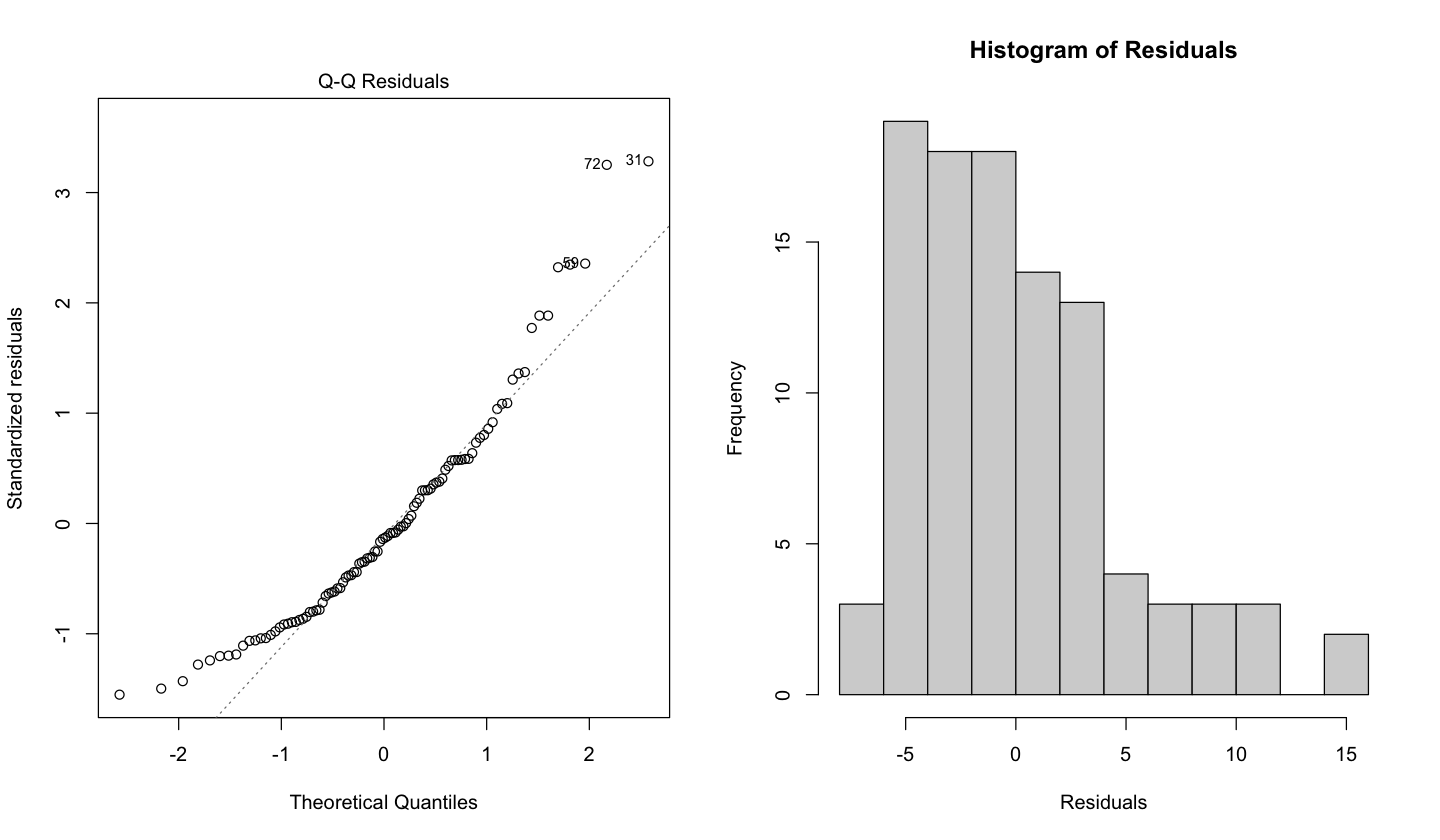

In [4]:
example_non_normality()

Recall the **$Q$-$Q$ plot** and **histogram of residuals** are graphical tools that help us to assess the normality assumption as follows:

- In the case of the $Q$-$Q$ plot, the ideal result is having all the data points lying on the 45° degree dotted line. This result means that all **standardized residuals** coming from the fitted model are equal to the theoretical quantiles coming from the **Standard Normal distribution**, i.e., $\mathcal{N}(0, 1)$. However, for the case above, a considerable proportion of these data points is not lying on the 45° degree dotted line, suggesting **non-normality**.

- For the histogram of residuals, we would expect a **bell-shaped** form as in the Normal distribution. Nonetheless, the plot above suggests a right-skewed distribution (also known as positive skewed).

```{important} 
A distributional misspecification (i.e., assuming normality when it is not the case) has severe implications for the associated tests ($t$ and $F$-tests). The distributions of the test statistics under $H_0$ rely on the normality assumption! 
```

On the other hand, **homoscedasticity** can be assessed via the diagnostic plot of **residuals vs. fitted values**. The ideal result would show a uniform cloud of data points. However, the plot below (coming from an OLS model fitted with simulated data) shows a clear pattern composed of two funnel shapes. This pattern indicates non-constant variance, i.e., **heteroscedasticity**.

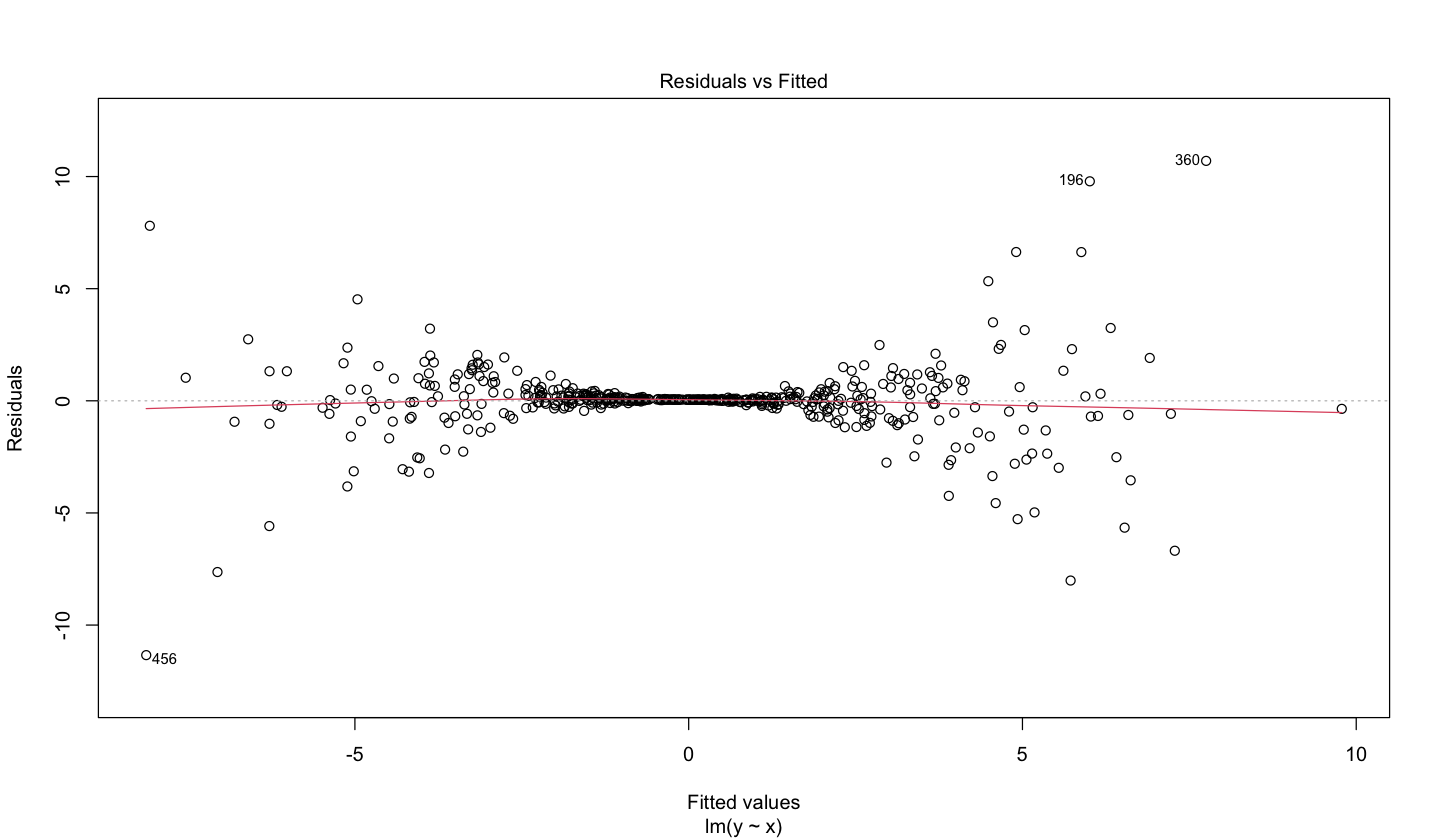

In [5]:
example_heteroscedasticity()

Below, you can find further information on the implications of assumption violations.

#### 2.6.1. Distributional Misspecification

Fulfilling the model's assumptions {eq}`OLS-assumptions` on the errors $\varepsilon_i$ considerably impacts the statistical tests of the OLS model.

```{important} 
The distributions of the test statistics, such as the $t$ or the $F$-values, heavily rely on the normality of the $\varepsilon_i$s. Suppose we do not fulfil the normality on the random component. In that case, these test statistics will not be reliable unless **our sample size $n$ is large enough** (i.e., **an asymptotical approximation**). Not fulfilling the normality assumptions would put us at stake in drawing misleading statistical conclusions on significance.

Recall that hypothesis testing assumes a particular distribution under the null hypothesis $H_0$, which is related to these random components' normality for this model in the $t$ and $F$-tests.
```

#### 2.6.2. Random Components with Non-Zero Mean

Suppose we misspecified the mean in our OLS regression model for our random components, i.e., 

$$\mathbb{E}(\varepsilon_i) = c \neq 0.$$ 

This misspecification would be a mild violation. It will be absorbed by the intercept $\beta_0$ leading to 

$$\beta_0^* = \beta_0 + c,$$ 

and reflected in the model estimate for the intercept.

```{admonition} Definition of Lurking Variable
:class: tip
Note that this $c$ is constant over all the $n$ $\varepsilon_i$s. Nonetheless, suppose there is a further regressor $X_{i, k + 1}$ not taken into account in our data modelling. In that case, we are at stake in obtaining **biased model estimates** and misleading statistical conclusions on significance. 

Therefore, we define this further regressor $X_{i, k + 1}$ as a **lurking variable**.
```

#### 2.6.3. Heterocedasticity

We already defined homoscedasticity as the fact that all $\varepsilon_i$s have $\sigma^2$ as a common variance. However, this assumption commonly gets violated in multiple linear regression and is called **heteroscedasticity**: the variance of the $\varepsilon_i$s is not constant.

```{important} 
A common approach to solve heterocedasticity is a response transformation, usually logarithmical if it is positive.
```

#### 2.6.4. Correlated Random Components

When we have correlated random components, we are also at the stake of assuming misspecified distributions on our statistical tests. Again, this correlation leads to misspecified distributions in the $t$ and $F$-tests since the test statistics heavily rely on independence under the null hypothesis $H_0$. 

Alternative modelling could deal with this matter (e.g., **mixed-effects models** to be covered in this course). 

```{admonition} Note
:class: note
The independence between random components in OLS could be confirmed via a **Durbin-Watson test**. You can find more information about this test [**here**](https://www.statology.org/durbin-watson-test/).
```

## 3. When Ordinary Least-squares Regression Does Not Suffice

The OLS model from **DSCI 561** allows the response to take on any real number. Nonetheless, this is not entirely true in many real-life datasets. 

We usually encounter cases where the response's range is restricted. Therefore, this linear regression model is not suitable. Thus, **what can we do about it?**

```{important} 
The statistical literature offers an interesting set of regression models that could deal with different types of responses in real life. This set of models will be introduced in this course while providing illustrative examples we might encounter in data analysis.
```

We could list some examples where the response is not suitable for the OLS model:

- **Non-negative values.** The median value of owner-occupied homes in USD 1000's (`medv`) in the dataset `BostonHousing` [(Harrison and Rubinfeld, 1978)](http://ubc.summon.serialssolutions.com/2.0.0/link/0/eLvHCXMwnV07T8MwELYQDLDwKCDeyghDaOy0TixVSICourBVYrRc50wBNVRtQeLfc-fEpYAQiMF5nB9JbOf8Obn7zFgqzpP4i04wgANV7iQgPC-gZTOligRsAiYRhfWLOSya6pz_8EOfyyZhgjiRSp5m-RmteClj0sBpm5NBV-_2aq6H88QvLTfPEBznfijk88BE9pkWQd-nMWplAmOwC-NPd4PdBS-eYHjyxS_wG7njH59pk63XkDS6rPrQFluCssFWg8fytMF2bz684TBhrQ6m22zWGZnJ00UPCiLY7TT9WTR8JmP6-6iKHBNr0TTEmbKIEHLWcQWMUBDiED7XcrwNUwZxJTIPk1qww_rdm_51L66XcYh5KomtVGZGtJwcEO-NQplVvCDqQwlKcGvBtp2yhjxghZFu4KRSTqZcDFomFZDusuXyuYQ9FqlMICISMLA0L3WpqrhpXAvz2MLl-ywOTajHFVmHDlZsVMea6lhnufZ1rAWmD-38x_RZ6Ay6BigV8NDYor_kvPR9Z34ZAHgEqmT9qlPTxvCGgeOcHncPdIhhjCHnWKrQw9no4N9XP2Rr3DMp05ejI7Y8m7zAsaeZOPGvjN9evwO2Ww2r).

```{admonition} The Boston Housing Dataset 
The dataset `BostonHousing` contains information of 506 tracts of Boston from the 1970 US Census. Suppose we want to make inference or predict the response `medv`, subject to the other 13 regressors in the dataset. In this case, the nature of the response does not allow it to take on negative values.
```

In [6]:
data(BostonHousing)
str(BostonHousing)

'data.frame':	506 obs. of  14 variables:
 $ crim   : num  0.00632 0.02731 0.02729 0.03237 0.06905 ...
 $ zn     : num  18 0 0 0 0 0 12.5 12.5 12.5 12.5 ...
 $ indus  : num  2.31 7.07 7.07 2.18 2.18 2.18 7.87 7.87 7.87 7.87 ...
 $ chas   : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ nox    : num  0.538 0.469 0.469 0.458 0.458 0.458 0.524 0.524 0.524 0.524 ...
 $ rm     : num  6.58 6.42 7.18 7 7.15 ...
 $ age    : num  65.2 78.9 61.1 45.8 54.2 58.7 66.6 96.1 100 85.9 ...
 $ dis    : num  4.09 4.97 4.97 6.06 6.06 ...
 $ rad    : num  1 2 2 3 3 3 5 5 5 5 ...
 $ tax    : num  296 242 242 222 222 222 311 311 311 311 ...
 $ ptratio: num  15.3 17.8 17.8 18.7 18.7 18.7 15.2 15.2 15.2 15.2 ...
 $ b      : num  397 397 393 395 397 ...
 $ lstat  : num  4.98 9.14 4.03 2.94 5.33 ...
 $ medv   : num  24 21.6 34.7 33.4 36.2 28.7 22.9 27.1 16.5 18.9 ...


- **Binary outcomes (Success or Failure).** Whether a tumour is `benign` or `malignant` (`Class`) in the dataset `BreastCancer` [(Wolberg and Mangasarian, 1990)](https://libkey.io/libraries/498/articles/35797998/full-text-file?utm_source=api_542).

```{admonition} The Breast Cancer Dataset 
The dataset `BreastCancer` contains information of 699 biopsy results. Suppose we want to make inference or predict the response `Class`, subject to the other 9 regressors in the dataset (except `Id`). The response is discrete of binary type.
```

In [7]:
data(BreastCancer)
str(BreastCancer)

'data.frame':	699 obs. of  11 variables:
 $ Id             : chr  "1000025" "1002945" "1015425" "1016277" ...
 $ Cl.thickness   : Ord.factor w/ 10 levels "1"<"2"<"3"<"4"<..: 5 5 3 6 4 8 1 2 2 4 ...
 $ Cell.size      : Ord.factor w/ 10 levels "1"<"2"<"3"<"4"<..: 1 4 1 8 1 10 1 1 1 2 ...
 $ Cell.shape     : Ord.factor w/ 10 levels "1"<"2"<"3"<"4"<..: 1 4 1 8 1 10 1 2 1 1 ...
 $ Marg.adhesion  : Ord.factor w/ 10 levels "1"<"2"<"3"<"4"<..: 1 5 1 1 3 8 1 1 1 1 ...
 $ Epith.c.size   : Ord.factor w/ 10 levels "1"<"2"<"3"<"4"<..: 2 7 2 3 2 7 2 2 2 2 ...
 $ Bare.nuclei    : Factor w/ 10 levels "1","2","3","4",..: 1 10 2 4 1 10 10 1 1 1 ...
 $ Bl.cromatin    : Factor w/ 10 levels "1","2","3","4",..: 3 3 3 3 3 9 3 3 1 2 ...
 $ Normal.nucleoli: Factor w/ 10 levels "1","2","3","4",..: 1 2 1 7 1 7 1 1 1 1 ...
 $ Mitoses        : Factor w/ 9 levels "1","2","3","4",..: 1 1 1 1 1 1 1 1 5 1 ...
 $ Class          : Factor w/ 2 levels "benign","malignant": 1 1 1 1 1 2 1 1 1 1 ...


- **Count data.** The number of physician office visits (`visits`) in the dataset `NMES1988` [(Deb and Trivedi, 1997)](https://ubc.summon.serialssolutions.com/2.0.0/link/0/eLvHCXMwnV1tS8MwEA5uftAvvk6cL6N_oK5L0pfJUEr34gQZ4j75JaZLCsOtzqng_os_1kuTDjsVwU-lF9oL5Mg9x909hxDBZ469cick3G0GggcJ9YXHSUIDb6RyXn6DgsPmcqVUx89bY1SVZVYmmCX1AS_FE1nHOHCxiy9nz7aaHqWyrGaURgmVwEI1Te7yPlYM7BpLEtvHLi54IF2E-AWZUuNautvoId9FXlOy0vJX5G38x3Z30JaBnVao7WQXrcl0D23kXckv--ijNeXzx4u2nPJUtOrZi6VlAGstk88pLqjepaIkXlgAKK2OGv09WZi1c7MYWt2xQrjFT27G7yqJURSGhuncSCto2O0MoyvbTG6wAT4Ejg0xVSAVdTyn2PeJkBC4yKRBhUdHHuFurPphMSAzAXCPOwnAGgHOWkoVrwEoPUDl9CmVh6rySgDkGIlmTByaSCfmIwExYRx7SSBjX1bRID9MNtP8HEwzMWPG7vpRX6XYmwxgnMtUTY0DD8wIIw3CWNhvs-uwQ6kDEodFA4ZZr4oq2REuf2fOr4puMxv5puYPLT8qMZKjX3Qdo01Nk6sKK09Q-XX-Jk8zXogaWm9H94NeLbPxT5yWAM4). This response takes on count values ($0, 1, 2, 3, \dots$).

```{admonition} The US National Medical Expenditure Survey Dataset 
The `NMES1988` dataset contains cross-sectional data from the US National Medical Expenditure Survey (NMES) between 1987 and 1988. It is a sample of 4,406 individuals of ages 66 and above covered by Medicare with 19 different variables. Suppose we are interested in making inference or predicting the number of `visits` subject to regressors `age`, `gender`, and `income`.
```

In [8]:
data(NMES1988)
str(NMES1988)

'data.frame':	4406 obs. of  19 variables:
 $ visits   : int  5 1 13 16 3 17 9 3 1 0 ...
 $ nvisits  : int  0 0 0 0 0 0 0 0 0 0 ...
 $ ovisits  : int  0 2 0 5 0 0 0 0 0 0 ...
 $ novisits : int  0 0 0 0 0 0 0 0 0 0 ...
 $ emergency: int  0 2 3 1 0 0 0 0 0 0 ...
 $ hospital : int  1 0 3 1 0 0 0 0 0 0 ...
 $ health   : Factor w/ 3 levels "poor","average",..: 2 2 1 1 2 1 2 2 2 2 ...
  ..- attr(*, "contrasts")= num [1:3, 1:2] 1 0 0 0 0 1
  .. ..- attr(*, "dimnames")=List of 2
  .. .. ..$ : chr [1:3] "poor" "average" "excellent"
  .. .. ..$ : chr [1:2] "poor" "excellent"
 $ chronic  : int  2 2 4 2 2 5 0 0 0 0 ...
 $ adl      : Factor w/ 2 levels "normal","limited": 1 1 2 2 2 2 1 1 1 1 ...
 $ region   : Factor w/ 4 levels "northeast","midwest",..: 4 4 4 4 4 4 2 2 2 2 ...
  ..- attr(*, "contrasts")= num [1:4, 1:3] 1 0 0 0 0 1 0 0 0 0 ...
  .. ..- attr(*, "dimnames")=List of 2
  .. .. ..$ : chr [1:4] "northeast" "midwest" "west" "other"
  .. .. ..$ : chr [1:3] "northeast" "midwest" "west"
 $ age

## 4. Paving the Way to Generalized Linear Models

When we are using a set of regressors (or **predictors**) to explain (or **predict**) our response, we have to establish a mathematical relationship between them. This is called a **functional form** (i.e., **model function**). For instance, in the case of the regressor $X$ and response $Y$, we could have:

- **Linear:** $Y = \beta_0 + \beta_1 X$.
- **Exponential:** $Y = e^{\beta_0 + \beta_1 X}$.
- **In general:** $Y = f(X)$.

### 4.1. Nature of the Model Function

Once we establish the model function between our variables, we have to specify the nature of it:

- **Deterministic.** For each one of the values of the regressor $X$, there is a single value of $Y$.
- **Stochastic.**  Each value of $X$ has a probability distribution associated to $Y$.

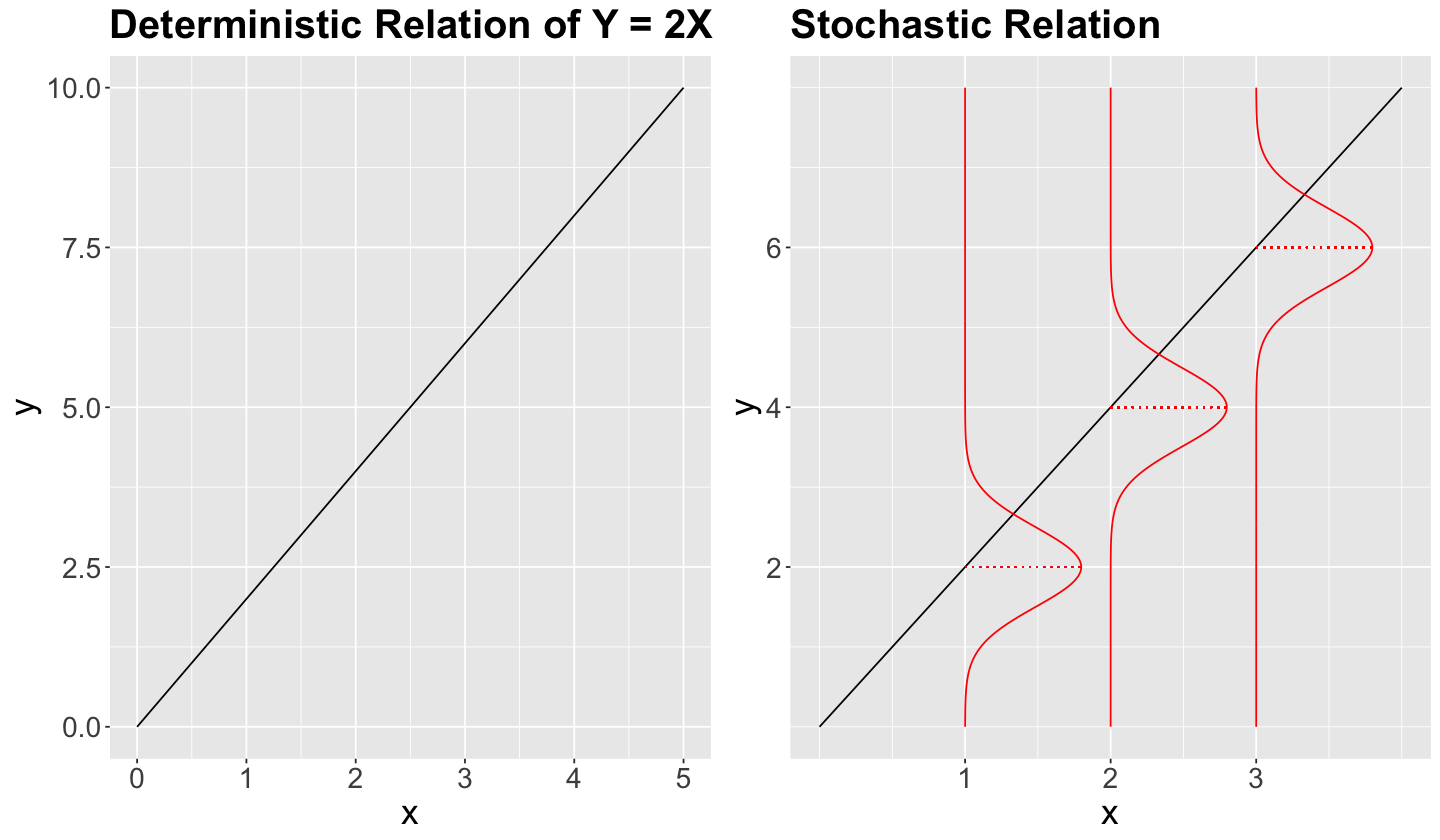

In [9]:
options(repr.plot.height = 7, repr.plot.width = 12)
suppressWarnings(print(plot_grid(example_deterministic_relation(), example_stochastic_relation(), nrow = 1)))

### 4.2. The Regression Problem

The term **regression** can be extended beyond a linear relationship between the response and regressors. From {ref}`DS-workflow-preamble`, a regression model can be used for two purposes:

- **Inference.** We want to determine whether a significant statistical association/causation exists between the response and regressor (e.g., $t$-tests in OLS regression) and estimate the **effect size**.

```{important} 
Note there is **uncertainty** associated with the parameter estimation used in inference since we rely on an observed random sample (i.e., our **training set**). Moreover, we control and report this uncertainty via **confidence intervals**).
```

- **Prediction.** Given new values for the regressors, we want to predict the corresponding value of the response subject to the effect estimates.

```{important} 
Note that there is **uncertainty** associated with this response prediction since it is obtained using estimated modelling parameters from an observed random sample (i.e., our **training set**). Furthermore, we control and report this uncertainty via **prediction intervals**).
```

### 4.3. Black-box Models

A model such as in the case of OLS regression, specifies the functional form between the regressors and the response along with assumptions on the system or phenomenon we aim to model. This allows **interpretability**. On the other hand, a **black-box model** is focused on **optimizing predictions** subject to a set of regressors with less attention on the internal model's process.

### 4.4. Interpretability in Linear Models

A crucial characteristic of linear models is their **relative easiness to interpret the effects of the regressors on the response** (via the model's coefficients). Moreover, their predictive ability is fair in general. An additional takeaway on this class of tools is their ability to go beyond the conditioned modelling of the response's means (e.g., **medians or certain quantiles**).

### 4.5. The Types of Parametric Assumptions

The concept of a **parametric model** varies depending on the field:

- In **Computer Science**, a parametric model assumes a functional relationship between the regressors and response (e.g., linear).
- In **Statistics**, a parametric model has distributional assumptions on its components.

### 4.6. An example where OLS regression totally goes wrong

We have to be careful when using linear models in specific complex datasets if we only appeal to their easiness of interpretability. When we do not capture the right functional form between the regressors and the response, the chances of having a misspecified model are high. For the sake of this example, we will build a simulated dataset similar to the previous **Example 3**. Assume that the true functional form in this 2-$d$ example is as follows:

```{math}
\begin{align*}
Y_i &= \beta_0 + \beta_1 g(X_i) + \varepsilon_i \\
&= \beta_0 + \beta_1 \sin(X_i) + \varepsilon_i \\
&= 5 + 10 \sin(X_i) + \varepsilon_i
\end{align*}
```

with 

```{math}
\begin{gather*}
\mathbb{E}(\varepsilon_i) = 0 \\
\text{Var}(\varepsilon_i) = \sigma^2 \\
\varepsilon_i \sim \mathcal{N}(0, \sigma^2) \\
\varepsilon_i \perp \!\!\! \perp \varepsilon_k \; \; \; \; \text{for} \; i \neq k  \; \; \; \; \text{(independence)}.
\end{gather*}
```

We simulate a dataset of $n = 234$ observations with $x_i \in [2, 13.65]$. **Function `rnorm()`** provides our Normal error components with the parameters specified above. The code below simulates these data and then provides a scatterplot.

In [10]:
set.seed(123)
sin_data <- tibble(
  x = seq(2, 13.65, 0.05),
  y = 5 + 10 * sin(x) + rnorm(length(seq(2, 13.65, 0.05)), 0, 1.5)
)
sin_data

range(sin_data$y)

x,y
<dbl>,<dbl>
2.00,13.25226
2.05,13.52836
2.10,15.97016
⋮,⋮
13.55,13.18966
13.60,13.91343
13.65,12.72883


[1] -7.284775 17.173099

```{important} 
From the above code, given that we are running a data simulation, note that the real values for our regression parameters are actually $\beta_0 = 5$ and $\beta_1 = 10$. Recall that we will not know these real values in practice, and **it is in our best interest to estimate them via suitable modelling on our training data**.
```

`geom_smooth()` using formula = 'y ~ x'


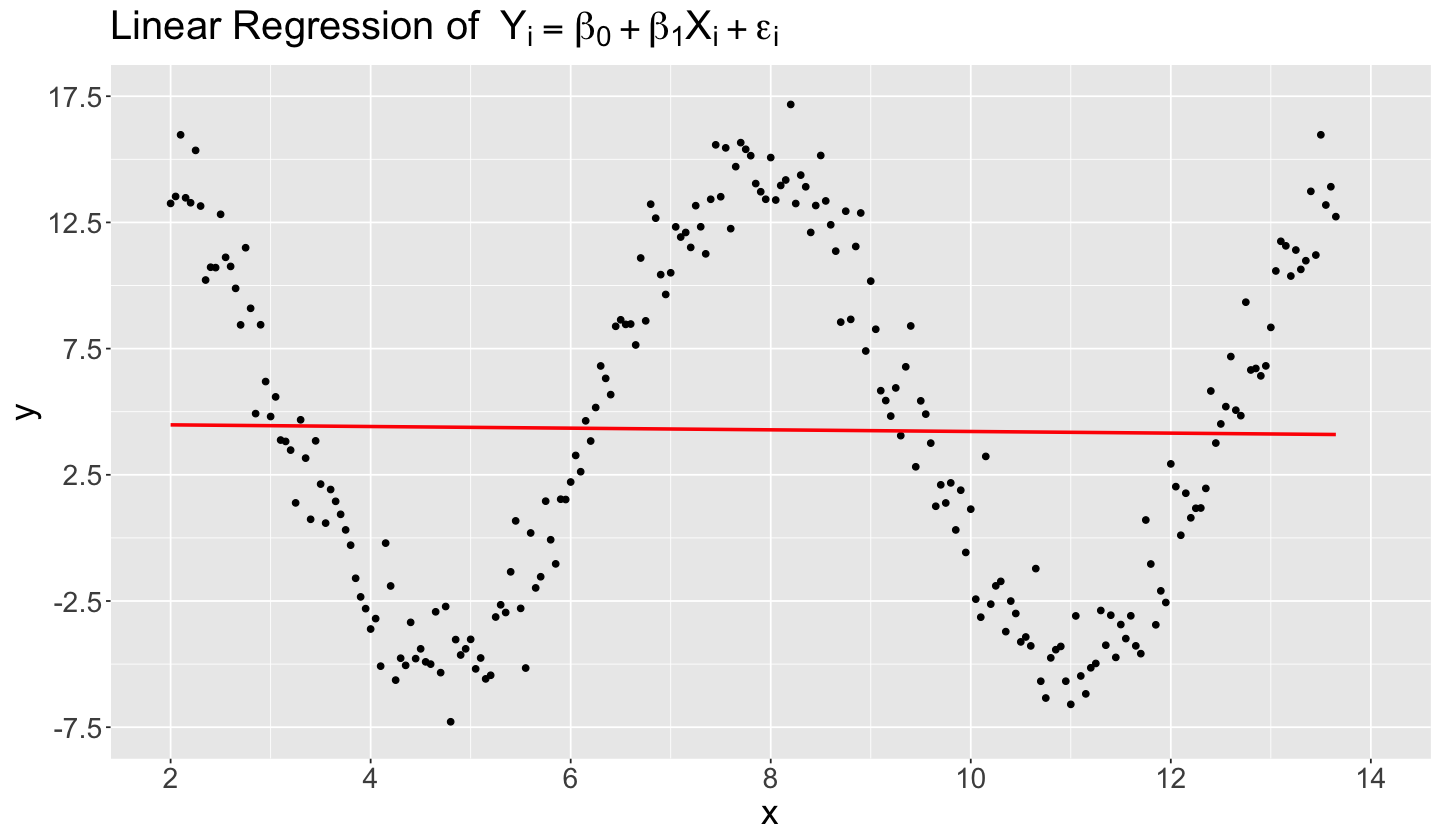

In [11]:
sin_data |> 
  ggplot() +
  geom_point(aes(x, y)) +
  geom_smooth(aes(x, y), method = "lm", se = FALSE, color = "red") +
  ggtitle(bquote("Linear Regression of " ~ Y[i] == beta[0] + beta[1] * X[i] + epsilon[i])) +
  theme(
      plot.title = element_text(size = 24),
      axis.text = element_text(size = 17),
      axis.title = element_text(size = 21)
    ) +
  scale_x_continuous(breaks = seq(2, 14, 2), limits = c(2, 14)) +
  scale_y_continuous(breaks = seq(-7.5, 17.5, 5), limits = c(-7.5, 17.5))

The code above also fits a linear regression, with `method = "lm"` via `geom_smooth()`, assuming that the "*right functional form*" is 

$$Y_i = \beta_0^* + \beta_1^* X_i + \varepsilon_i.$$ 

Nonetheless, if we use `lm()` in `sin_function_model`, the fitted regression line is **almost flat** (i.e., $\hat{\beta}_1^* = -0.033$) and located on $y = 4.545$ (i.e., $\hat{\beta}_0^* = 4.545$). Note that the slope is not even significant given a $p \text{-value} = 0.806$. 

```{important} 
The below result is expected in a **misspecified model** since the OLS method attempts to reduce the squared distance between the observed and estimated response values **across all points**. Hence, this attempt has a serious impact on a sinusoidal curve, like in this example.
```

In [12]:
sin_function_model <- lm(y ~ x, data = sin_data)
tidy(sin_function_model) |> 
  mutate_if(is.numeric, round, 3)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),4.545,1.136,4.001,0.000
x,-0.033,0.133,-0.246,0.806


In [13]:
glance(sin_function_model) |> 
  mutate_if(is.numeric, round, 3)

r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual,nobs
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,-0.004,6.886,0.061,0.806,1,-782.543,1571.086,1581.452,11002.15,232,234


```{admonition} Note
:class: warning
Before concluding anything about the model estimates, we have to make sure that we are setting up an adequate functional form. This is why [**feature engineering**](https://github.com/UBC-MDS/DSCI_573_feat-model-select) is essential as in **DSCI 573**.
```

### 4.7. Let us make it right!

Having fitted a misspecified model as we previously did, let us now make it right. Still, via `sin_data`, we will fit another OLS. However, this time, we will fit the model with a corresponding regressor sinusoidal transformation on column `X` such that:

In [14]:
sin_data <- sin_data |>
  mutate(sin_x = sin(x))
sin_data

x,y,sin_x
<dbl>,<dbl>,<dbl>
2.00,13.25226,0.9092974
2.05,13.52836,0.8873624
2.10,15.97016,0.8632094
⋮,⋮,⋮
13.55,13.18966,0.8325135
13.60,13.91343,0.8591618
13.65,12.72883,0.8836626


Then, we refit our OLS model:

In [15]:
sin_function_right_model <- lm(y ~ sin_x, data = sin_data)

Then, let us check our `tidy()` output along with the corresponing 95% confidence intervals, and the `glance()` output:

In [16]:
tidy(sin_function_right_model, conf.int = TRUE) |>
  mutate_if(is.numeric, round, 3)

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),4.996,0.093,53.689,0,4.813,5.179
sin_x,9.870,0.136,72.524,0,9.602,10.139


In [17]:
glance(sin_function_right_model) |> 
  mutate_if(is.numeric, round, 3)

r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual,nobs
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.958,0.958,1.416,5259.759,0,1,-412.354,830.709,841.075,464.909,232,234


Right on! We made an **accurate estimation** of $\beta_0 = 5$ and $\beta_1 = 10$, which is $\hat{\beta}_0 = 4.996$ and $\hat{\beta}_1 = 9.870$ whose confidence intervals give us a good insight on the low uncertainty of these point estimates (i.e., we caught the **real regression parameters** within the intervals). Moreover, we have stistical significance on our regression estimates (check the `p.value` column in the `tidy()` output).

Moreover, the `adj.r.squared` is quite acceptable: $0.958$.

Now, let us plot the **in-sample predictions** from `sin_function_right_model` in blue along with the ones from the misspecified `sin_function_model` in red (we also include the 95% **confidence intervals for prediction** as shaded gray areas):

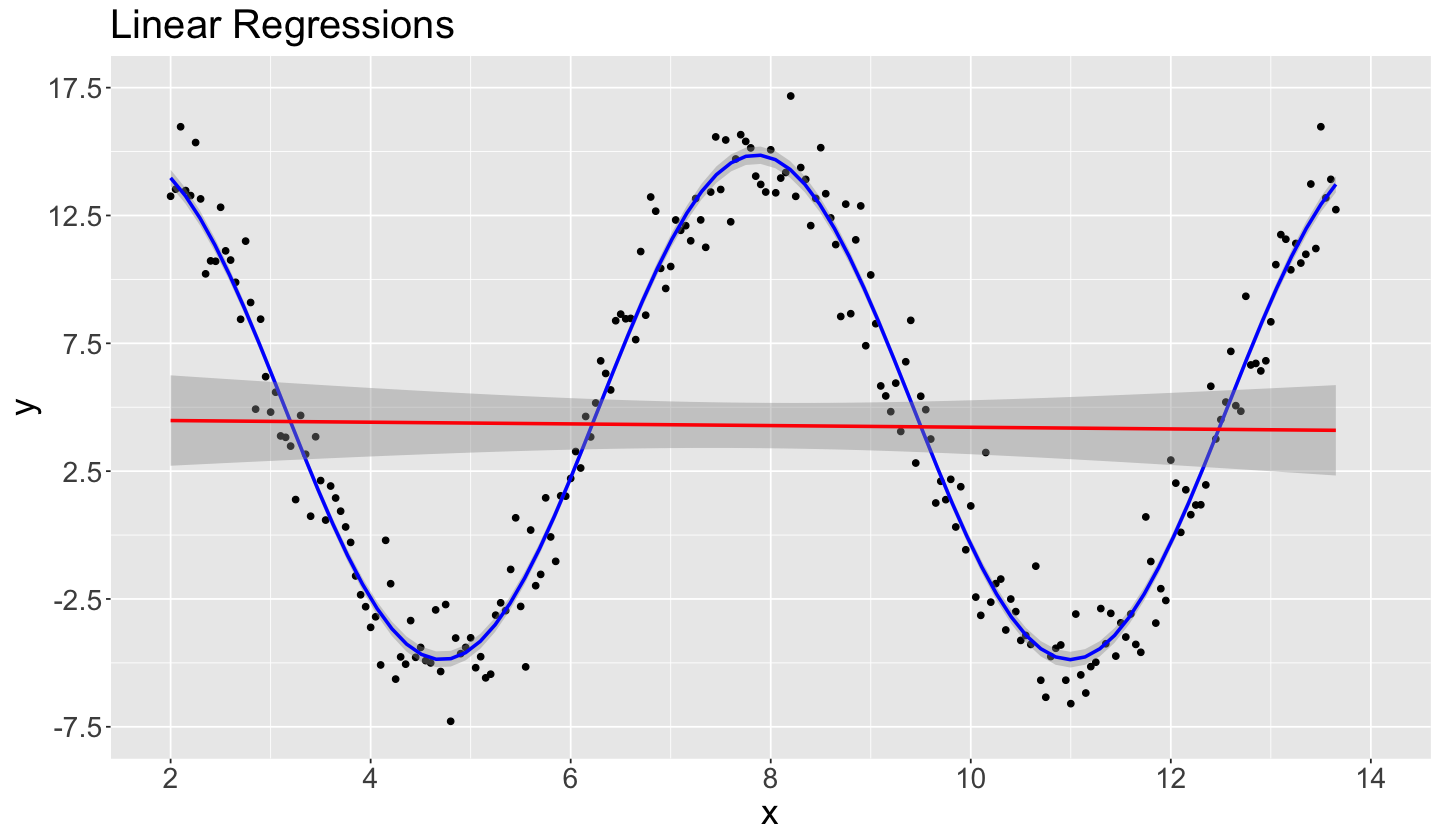

In [18]:
ggplot(data = sin_data) +
  geom_point(aes(x, y)) +
  geom_smooth(aes(x, y), method = "lm", formula = y ~ sin(x), color = "blue") +
  geom_smooth(aes(x, y), method = "lm", formula = y ~ x, color = "red") +
  ggtitle("Linear Regressions") +
  theme(
      plot.title = element_text(size = 24),
      axis.text = element_text(size = 17),
      axis.title = element_text(size = 21)
    ) +
  scale_x_continuous(breaks = seq(2, 14, 2), limits = c(2, 14)) +
  scale_y_continuous(breaks = seq(-7.5, 17.5, 5), limits = c(-7.5, 17.5))

Note our blue estimated regression line via `sin_function_right_model` provides a great fit for our training data, which is not the case for the red estimated regression curve from the misspecified `sin_function_model`. Moreover, our confidence intervals for prediction for `sin_function_right_model` are narrower, indicating a low uncertainty on our predictions (compared to `sin_function_model`).

```{important} 
We can repeat the above prediction procedure by using a further **test set** (different from the **training set** `sin_data`) via estimates from `sin_function_right_model`. That said, you must transform your raw column $x$ from this test set to $\sin(x)$ before obtaining the corresponding prediction $\hat{y}$.

Moreover, note this transformation on the regressor $X$ **is not equivalent** to the link function idea from GLMs. In this example, **we are basically making feature engineering**.
```

### 4.8. Restricted Response Ranges in Linear Regression

We initially listed different response types where the ranges are restricted. Now, the next matter to address is how to retain the easiness in model's interpretability. Recall that we might be using the model for inference purposes, and not predictions. Hence, a black-box model will not provide a straightforward interpretation.

We could use the following three modelling alternatives:

- **Data transformations.** For example, logarithmic transformations on the response.
- **Scientifically-backed functions.** We rely on subject-matter expertise. This backs regression modelling with actual scientific models. The theoretically-derived setup will indicate a meaningful relationship between response and regressors, whose parameters will be estimated with the model fitting.
- **Link functions.** This core concept in GLMs is detailed in the next section.

(link-function)=
### 4.9. Link Function

Recall OLS regression models a continuous response $Y_i$ (a random variable) via its conditioned mean (or expected value) $\mu_i$ subject to $k$ regressors $X_{i,j}$:

```{math}
\begin{align*}
\mu_i &= \mathbb{E}(Y_i \mid X_{i,1}, \ldots, X_{i,k}) = \beta_0 + \beta_1 X_{i,1} + \ldots + \beta_k X_{i,k} \\
& \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \text{since} \; \; \mathbb{E}(\varepsilon_i) = 0.
\end{align*}
```

Nonetheless, for instance, modelling the mean $\mu_i$ of a discrete-type response (such as binary or a count) is not straightforward. Hence, we rely on a **monotonic** and **differentiable** function $h(\mu_i)$ called the **link function**:

```{math}
\begin{align*}
h(\mu_i) &= \eta_i = \beta_0 + \beta_1 X_{i,1} + \beta_2 X_{i,2} + \ldots + \beta_k X_{i,k} \\
& \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \text{for} \; i = 1, \ldots, n.
\end{align*}
```

```{important}
The link function $h(\mu_i)$ is a crucial element in a GLM since it allows us to establish the functional relationship between the response and the regressor in this class of linear model. Note that the form of this link function will also change how we will interpret our estimated regression coefficients $\hat{\beta}_j$.
```

```{admonition} Note
:class: note
A GLM regression approach can also be applied to continuous responses. For instance, we can assume [**Normal**](https://cran.r-project.org/web/packages/GlmSimulatoR/vignettes/exploring_links_for_the_gaussian_distribution.html) or [**Gamma**](https://pj.freefaculty.org/guides/stat/Regression-GLM/Gamma/GammaGLM-01.pdf)-distributed responses.
```

```{admonition} Why monotonic and differentiable?
:class: tip
- The link function needs to be monotonic so we can allow putting the systematic component $\eta_i$ in terms of the corresponding mean $\mu_i$, i.e.:

$$\mu_i = h^{-1}(\eta_i).$$

- Furthermore, it needs to be differentiable **since we rely on MLE** to obtain $\hat{\beta}_0, \hat{\beta}_1, \dots, \hat{\beta}_k$.
```

That said, a GLM has the components of the conceptual regression model in a training set of $n$ elements as:

- **Random component.** Each *response* $Y_1,\ldots,Y_n$ is a random variable with its respective mean $\mu_i$.
- **Systematic component.** How the $k$ regressors come into the model denoted as a **linear combination**:

```{math}
:label: eq-glm-systematic_component
\begin{align*}
\eta_i &= \beta_0 + \beta_1 X_{i,1} + \beta_2 X_{i,2} + \ldots + \beta_k X_{i,k} \\
& \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \text{for} \; i = 1, \ldots, n.
\end{align*}
```

- **Link function.** The element that connects the **random component** with the **systematic component** $\eta_i$. The connection is made through $h(\mu_i)$:

$$
h(\mu_i) = \eta_i.
$$

```{important}
The **linear model** in {eq}`eq-glm-systematic_component` does not have an explicit **random component** as in the OLS model with a continuous response. **The randomness is expressed directly in the response $Y_i$ whose mean is $\mu_i$.** Moreover, this randomness is also reflected in the joint probability distribution of our training data when using MLE.
```

## 5. Poisson Regression

Moving along with GLMs, let us expand the regression mind map as in {numref}`reg-mindmap-2` to include Binary Logistic regression along with a new class of GLMs to model count-type responses: **Poisson and Negative Binomial regressions**. Further in this lecture, we will explain what **equidispersion** and **overdispersion** stand for.

```{figure} ../img/reg-mindmap-2.png
:height: 900px
:name: reg-mindmap-2
Expanded regression modelling mind map.
```

```{important} 
Both Poisson and Negative Binomial regressions belong to an overall GLM modelling approach called **count regression**. As its name says, this class of GLMs addresses count-type responses (i.e., integers). As in any other GLM, there will be a **link function** which will allow us **to relate the systematic component with the response's mean**. 

Note Poisson regression is the primary approach we should use when handling a count response.
```

### 5.1. The Crabs Dataset

``` {figure} ../img/crab.png
:height: 350px
The Crab comes back.
```

Let us introduce the dataset for this new class of GLMs. The data frame `crabs` ([Brockmann, 1996](https://ubc.summon.serialssolutions.com/2.0.0/link/0/eLvHCXMwrV3JasMwEBUlpZBLl7Sl6YY_oE4sy5sgFEpICKU9NadcjFYSmtghCyRf0t-tJC_EPhRaepMHS8jSSPM0M3oGALkdx67tCYRyKV0GacCp9CBX60RCySMcYiigy2qpOq_F1ZiMLqL0v-mFYrZvvd4JXXcPEnOUZbU1z6W-fxdoh6eO-XQUvDyGCnXrbK_hxCkDDCHKgs9KH20FelDOR_pzWxXbdYhljTEanoF10e8iC6V2SbDK9Pg_H3gOTnPsar1kynYBjkTSAs1yC923wMkkNaVL8NVbkNXn8wcxjJ8b0euaZysTvyuzVJUYH9i6Kpsl1ijVOSbTtPZ2f6V6nYuectnbbLGdb2tNLNP5fjkVi1J-BcbDwbg_svOfQNhMIRdsu4KHEnIsIiQYJoGQvsKQmAuOsE8lojRnrPEIlZQHHIUEEs8PBVHQjaJr0EjSRNwAS8ebmMNk4DHkRYgQSt2ARoxRnzuhJG2AitmNlxnVR3x4REI41sMf6-GP8-GPd20QmVn7RZV4MB7p0u3fq96BZpY-rn1B96CxWW3FgyGOeDR6_g1rIQSN)) is a dataset detailing the **counts of satellite male crabs** residing around a female crab nest. The code below renames the original response's name, `satell`, to `n_males`.

In [19]:
data(crabs)
crabs <- crabs |>
  rename(n_males = satell) |>
  dplyr::select(-y)
crabs

color,spine,width,n_males,weight
<fct>,<fct>,<dbl>,<int>,<int>
medium,bad,28.3,8,3050
dark,bad,22.5,0,1550
light,good,26.0,9,2300
⋮,⋮,⋮,⋮,⋮
light,good,28.0,0,2625
darker,bad,27.0,0,2625
medium,middle,24.5,0,2000


```{admonition} The Crabs Dataset
The data frame `crabs` contains 173 observations on horseshoe crabs (Limulus polyphemus). The response is **the count of male crabs** (`n_males`) around a female breeding nest. It is subject to four explanatory variables **related to the female crab**: `color` of the prosoma with four levels (categorical factor-type), the condition of the posterior `spine` with three levels (categorical factor-type), the continuous variables carapace `width` (cm), and `weight` (g).
```

```{admonition} Main Statistical Inquiries
Let us suppose we want to assess the following:

- Whether `n_males` and **female** carapace `width` are statistically associated and by how much.
- Whether `n_males` and **female** `color` of the prosoma are statistically associated and by how much.
```

### 5.2. Exploratory Data Analysis

Before getting into any estimation and inference, performing the corresponding exploratory EDA is necessary. Therefore, we will make a scatterplot of `n_males` versus female carapace `width` (see below), **even though `n_males` is not continuous**.

```{important} 
**Note the characteristic horizontal pattern in the points below since the $y$-axis has repeated counts associated with different female carapace `width` values**. This plot pattern paves the way for using a count regression model.
```

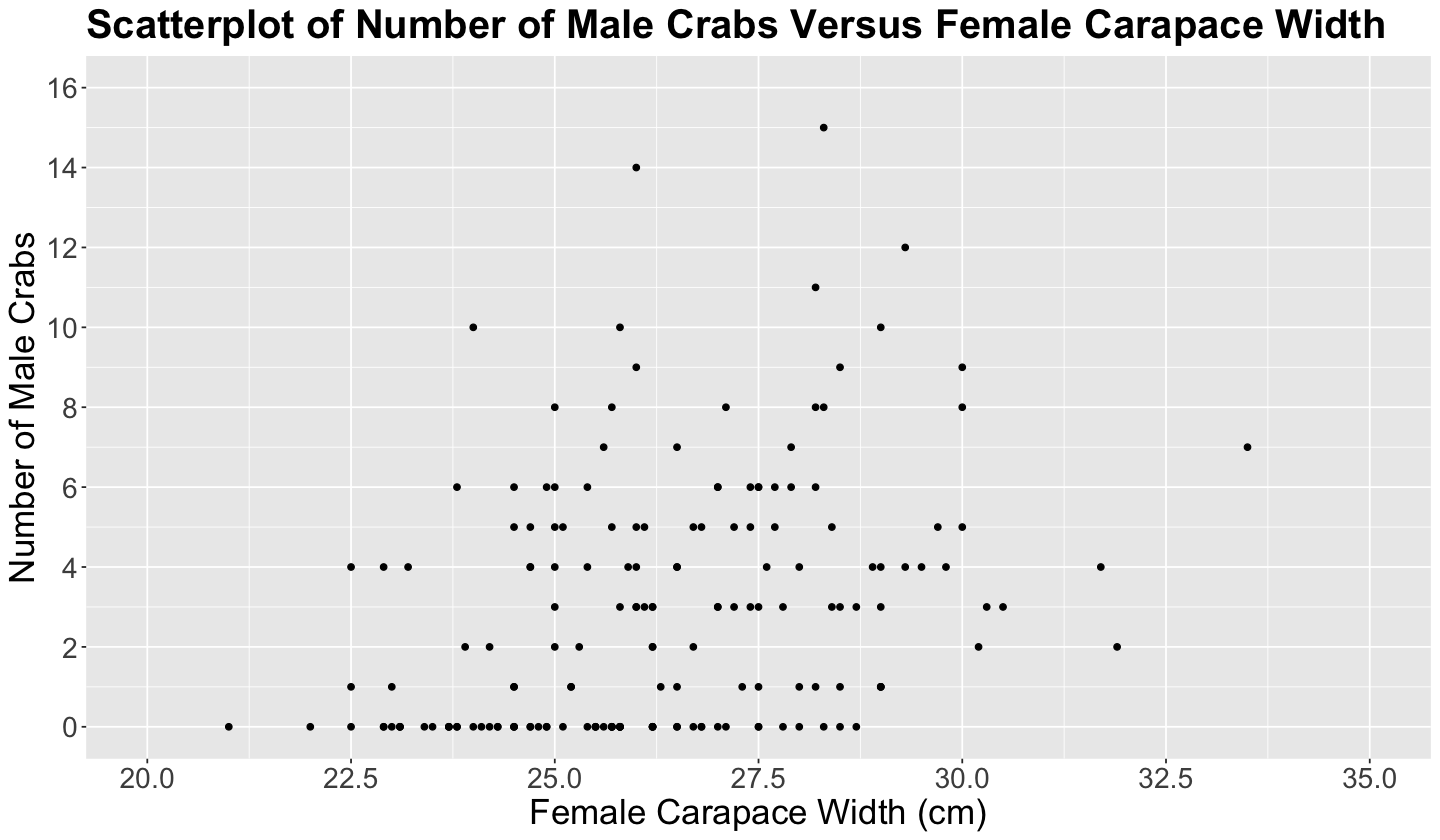

In [20]:
options(repr.plot.height = 7, repr.plot.width = 12)

plot_crabs_vs_width <- crabs |>
  ggplot() +
  geom_point(aes(width, n_males)) +
  labs(y = "Number of Male Crabs", x = "Female Carapace Width (cm)") +
  ggtitle("Scatterplot of Number of Male Crabs Versus Female Carapace Width") +
  theme(
    plot.title = element_text(size = 24, face = "bold"),
    axis.text = element_text(size = 17),
    axis.title = element_text(size = 21)
  ) +
  scale_x_continuous(limits = c(20, 35), breaks = seq(0, 35, by = 2.5)) +
  scale_y_continuous(breaks = seq(0, 16, 2), limits = c(0, 16))
plot_crabs_vs_width

```{exercise}
:label: lecture1-q2

By checking the above plot, do you think `n_males` increases with the female carapace `width`?

**A.** Of course!

**B.** Not really.

**C.** I am pretty uncertain about an increasing or decreasing pattern.
```

Therefore, since the scatterplot above is too hard to visualize, let us make a clever visualization. Firstly, we could calculate the average `n_males` using a few female carapace `width` groups.

In [21]:
options(repr.matrix.max.rows = 10)

group_avg_width <- crabs |> 
  mutate(intervals = cut(crabs$width, breaks = 10)) |> 
  group_by(intervals) |> 
  summarise(mean = mean(n_males), n = n()) 
group_avg_width

intervals,mean,n
<fct>,<dbl>,<int>
"(21,22.2]",0.000000,2
"(22.2,23.5]",1.000000,14
"(23.5,24.8]",1.769231,26
"(24.8,26]",2.976744,43
"(26,27.2]",2.531250,32
"(27.2,28.5]",4.151515,33
"(28.5,29.8]",4.000000,13
"(29.8,31]",4.857143,7
"(31,32.2]",3.000000,2


Then, we create another scatterplot using these `n_males` averages by female carapace `width` bins (as shown in the code below). Now it is easier to visualize and state, **descriptively**, that there is a positive relationship between female carapace `width` and `n_males`. 

```{important}
Nevertheless, we need to find a suitable regression model to statistically confirm this descriptive conclusion!
```

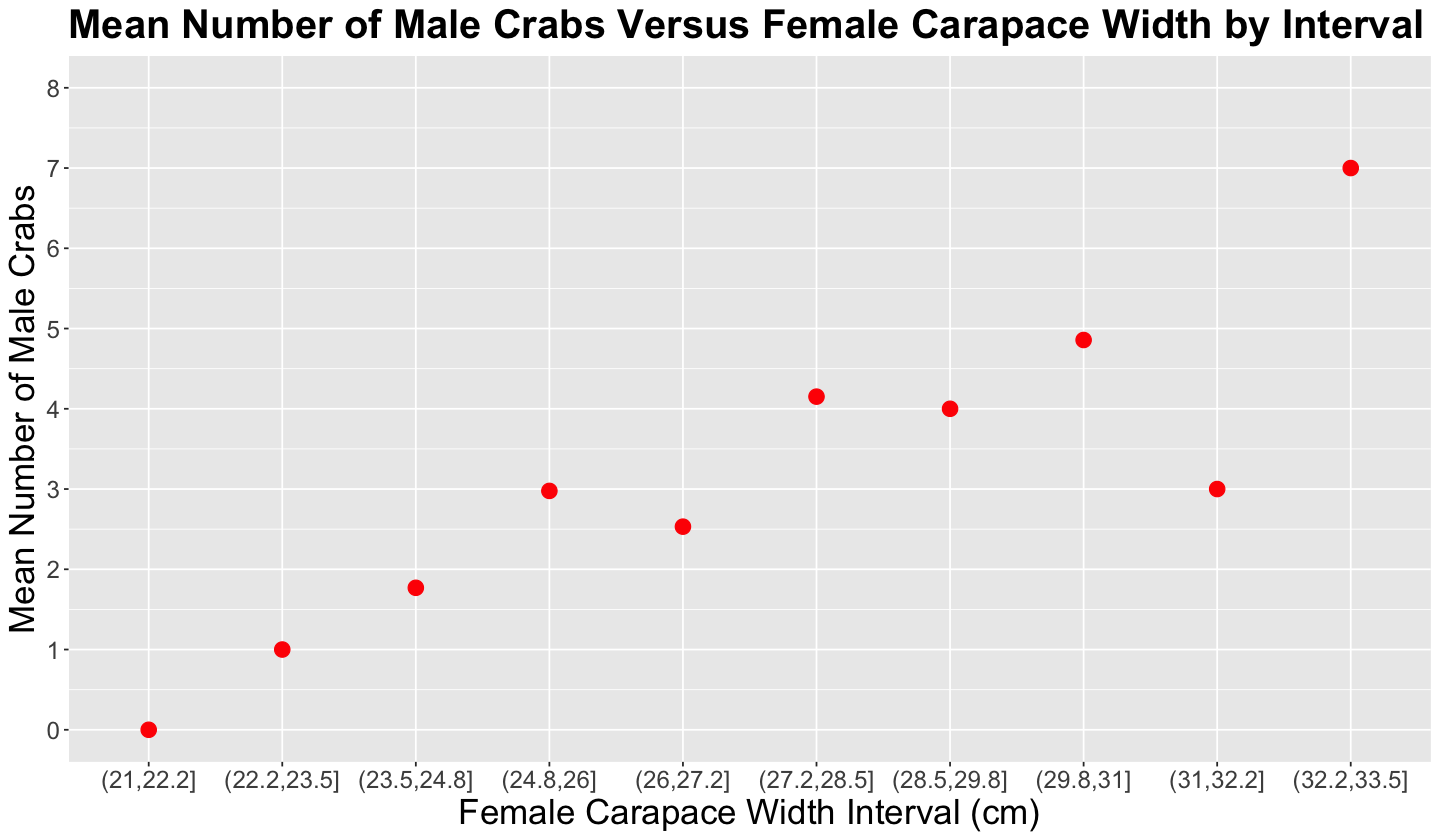

In [22]:
crabs_avg_width_plot <- group_avg_width |>
  ggplot() +
  geom_point(aes(intervals, mean), colour = "red", size = 4) +
  labs(y = "Mean Number of Male Crabs", x = "Female Carapace Width Interval (cm)") +
  ggtitle("Mean Number of Male Crabs Versus Female Carapace Width by Interval") +
  theme(
    plot.title = element_text(size = 24, face = "bold"),
    axis.text = element_text(size = 14.5),
    axis.title = element_text(size = 21)
  ) +
  scale_y_continuous(breaks = seq(0, 8, 1), limits = c(0, 8))
crabs_avg_width_plot

Finally, given that `n_males` is a count-type response, a more appropriate standalone plot is a **bar chart** (as shown in the code below). This bar chart is giving us visual evidence of a possible **Poisson random variable**, note the **right-skewness**.

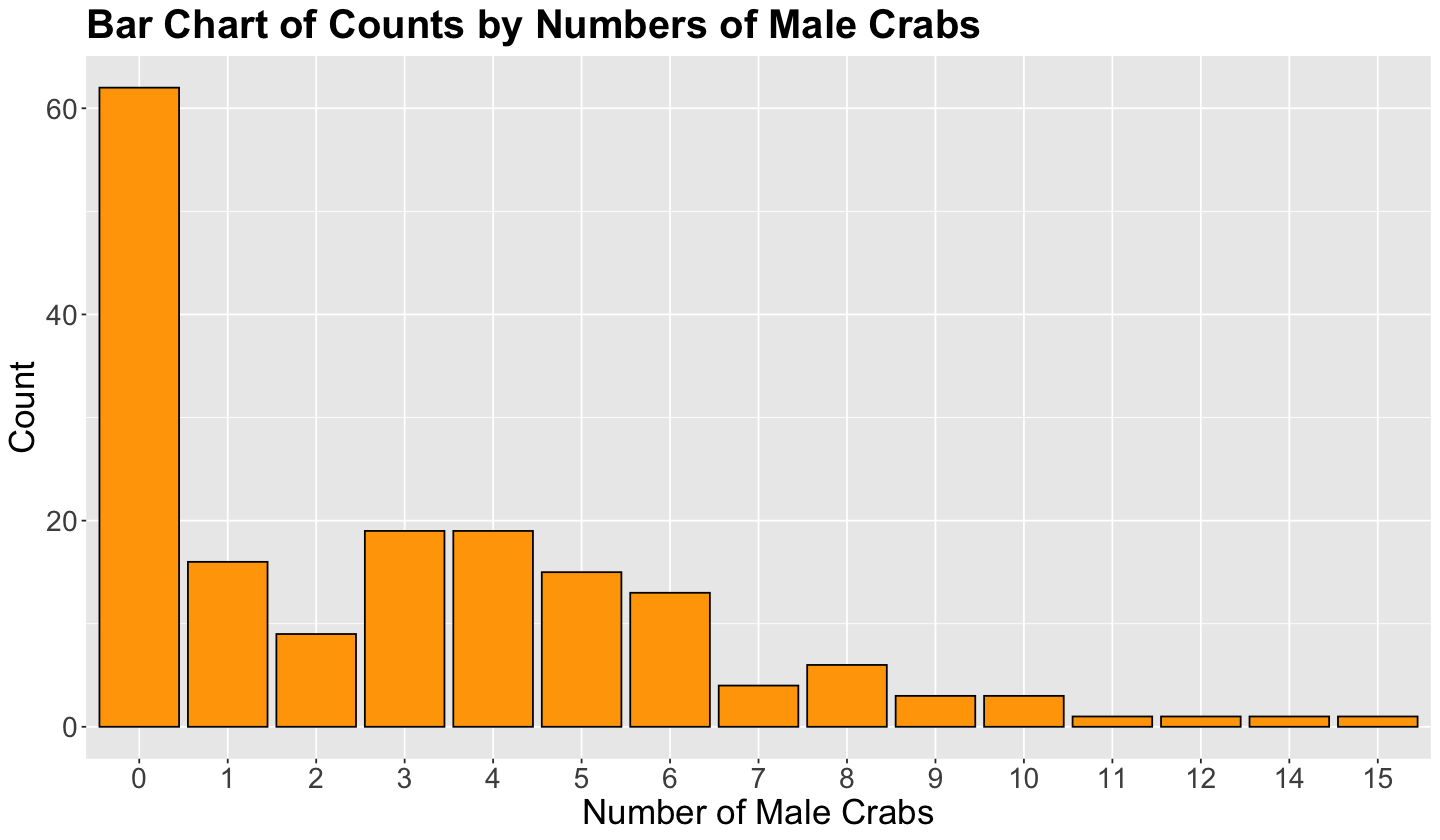

In [23]:
crabs_avg_width_bar_chart <- crabs |>
  ggplot() +
  geom_bar(aes(as.factor(n_males)), fill = "orange", color = "black") +
  theme(
    plot.title = element_text(size = 24, face = "bold"),
    axis.text = element_text(size = 17),
    axis.title = element_text(size = 21)
  ) +
  ggtitle("Bar Chart of Counts by Numbers of Male Crabs") +
  labs(x = "Number of Male Crabs", y = "Count")
crabs_avg_width_bar_chart

```{important}
The distribution of the counts in the response `n_males` is suggesting a possible Poisson distribution. Hence we might use Poisson regression to assess whether female carapace `width` is related to `n_males` and quantify the magnitude of the regressor's association (as well as the respective uncertainty associated with its estimation).
```

### 5.3. Data Modelling Framework

Besides OLS and Binary Logistic regressions, another alternative is count data modelling, as in **Poisson regression**. Unlike Binary Logistic regression, **we use counts as a response variable**. Hence, we have to modify the modelling framework to consider this fact. Poisson regression would be the primary resource when it comes to modelling counts. Note this model also fits into the GLM class. 

Recall that the random component in the OLS regression model, namely $\varepsilon_i$, is assumed to be Normal, making the response $Y_i$ Normal as in {eq}`Y-OLS_model-normal`. 

Therefore: 

> What is the distributional key difference between the Poisson and the OLS regression models in terms of the response? 

First of all, we have to specify what a Poisson random variable is. Recall [**DSCI 551**](https://ubc-mds.github.io/DSCI_551_stat-prob-dsci/notes/appendix-dist-cheatsheet.html#poisson), a Poisson random variable refers to discrete data with non-negative integer values that count something. **These counts could happen during a given timeframe or even a space such as a geographic unit!** 

```{important}
A particularity of a Poisson random variable is that its mean equals its variance (an inconsistency in [**Dimensional Analysis**](https://www.merriam-webster.com/dictionary/dimensional%20analysis)!). Thus, any factor that affects the mean will also affect the variance. This fact could be a potential drawback for using a Poisson regression model. Nonetheless, an alternative count modelling option could overcome this potential issue, which we will explain further.
```

The Poisson regression model assumes a random sample of $n$ count observations $Y_i$s, hence **independent** (**but not identically distributed!**), which have the following distribution:

$$Y_i \sim \text{Poisson}(\lambda_i).$$

Each $i$th observation has its own $\mathbb{E}(Y_i) = \lambda_i > 0$, which also implicates $\text{Var}(Y_i) = \lambda_i > 0$.

```{admonition} Definition of Equidispersion
:class: tip
The equality of the expected value and variance in a random variable is called **equidispersion**.
```

Parameter $\lambda_i$ is the risk of an event occurrence, coming from the definition of the Poisson random variable, **in a given timeframe or even a space**.

```{important}
We have to highlight another particularity in the Poisson distribution: **$\lambda_i$ is a continuous distributional parameter!**
```

For our `crabs` dataset, the events are the number of male crabs (`n_males`) around a space: **the female breeding nest**. Since we want to make inference on whether the female carapace `width` is related to the response `n_males`, then we could use Poisson regression.

Since the Poisson Regression model is also a GLM, we need to set up a [**link function**](link-function) $h(\lambda_i)$ for the mean.

Let $X_{\texttt{width}_i}$ be the $i$th value for the regressor `width` in our dataset. An easy modelling solution would be an **identity** link function as in 

$$
h(\lambda_i) = \lambda_i = \beta_0 + \beta_1 X_{\texttt{width}_i}.
$$ (eq-naive-poisson)

However, **we have a response range issue!**

The model {eq}`eq-naive-poisson` for $h(\lambda_i)$ has a significant drawback: **the right-hand side is allowed to take on even negative values**, which does not align with the nature of the parameter $\lambda_i$ (**that always has to be non-negative**). 

Recall the essential characteristic of a GLM that should come into play for a link function. In this class of models, the direct relationship between the original response and the regressors may be **non-linear** as in $h(\lambda_i)$. Hence, instead of using the identity link function $\lambda_i$, **we will use the natural logarithm of the mean: $\log(\lambda_i)$**.

Before continuing with the `crabs` dataset, let us generalize the Poisson regression model with $k$ regressors as:

```{math}
:label: poisson-model
\begin{equation*}
h(\lambda_i) = \log(\lambda_i) = \beta_0 + \beta_1 X_{i,1} + \dots + \beta_k X_{i,k}.
\end{equation*}
```

In model {eq}`poisson-model`, each one of the $k$ regression coefficients $\beta_{1}, \dots, \beta_{k}$ represents **the expected change in the natural logarithm of the mean $\lambda_i$ per unit change in their respective regressors $X_{i,1}, \dots, X_{i,k}$**. Nonetheless, we could make more sense in the interpretation by exponentiating {eq}`poisson-model`:

$$
\lambda_i = \exp{(\beta_0 + \beta_1 X_{i,1} + \dots + \beta_k X_{i,k})},
$$

where an increase in one unit in any of the $k$ regressors (**while keeping the rest of them constant**) **multiplies the mean $\lambda_i$ by a factor $\exp{(\beta_j)}$, for all $j = 1, \dots, k$**.

In the `crabs` dataset with female carapace `width` as a regressor, the Poisson regression model is depicted as:

$$
h(\lambda_i) = \log(\lambda_i) = \beta_0 + \beta_1 X_{\texttt{width}_i}.
$$

```{important}
As a side note, we have to clarify that the **systematic component** in the Poisson regression model is explicitly depicted by the regressors and their coefficients as in OLS regression. Nonetheless, the **random component** is implicitly contained in each random variable 

$$Y_i \sim \text{Poisson}(\lambda_i).$$
```

### 5.4. Estimation

Under a general framework with $k$ regressors, the **regression parameters** $\beta_0, \beta_1, \dots, \beta_k$ in the model are also unknown. In order to estimate them, we will use function `glm()` and its argument `family = poisson` (required to specify the Poisson nature of the response), which obtains the estimates $\hat{\beta}_0, \hat{\beta}_1, \dots \hat{\beta}_k$.

The estimates are obtained through **maximum likelihood** where we assume a **Poisson joint probability mass function** of the $n$ responses $Y_i$.

```{important}
For the sake of coding clarity, you could also use `family = poisson(link = "log")`. Nevertheless, `link = "log"` is a default in `glm()` for Poisson regression. Thus, `family = poisson` suffices when using the logarithmic link function.
```

In [24]:
poisson_model <- glm(n_males ~ width, family = poisson, data = crabs)

### 5.5. Inference

**The fitted regression model will be used to identify the relationship between the logarithm of the response's mean and regressors.** To determine the **statistical significance** of $\beta_j$ in this model, we also use the **Wald statistic**:

$$
z_j = \frac{\hat{\beta}_j}{\mbox{se} \left( \hat{\beta}_j \right)}
$$

to test the hypotheses

```{math}
\begin{gather*}
H_0: \beta_j = 0 \\
H_a: \beta_j \neq 0;
\end{gather*}
```
where the **null hypothesis** $H_0$ indicates that the $j$th regressor corresponding to $\beta_j$ does not have any association on the response variable in the model, and the **alternative hypothesis** $H_a$ otherwise. Provided the sample size $n$ is large enough, $z_j$ has an **approximately Standard Normal distribution** under $H_0$.

`R` provides the corresponding **$p$-values** for each $\beta_j$. The smaller the $p$-value, the stronger the evidence against the null hypothesis $H_0$. As in the previous regression models, we would set a predetermined significance level $\alpha$ to infer if the $p$-value is small enough. If the $p$-value is smaller than the predetermined level $\alpha$, then we could claim that there is evidence to reject the null hypothesis. Hence, $p$-values that are small enough indicate that the data provides evidence in favour of **association** (**or causation in the case of an experimental study!**) between the response variable and the $j$th regressor.

Furthermore, given a specified level of confidence where $\alpha$ is the significance level, we can construct approximate $(1 - \alpha) \times 100\%$ **confidence intervals** for the corresponding true value of $\beta_j$:

$$
\hat{\beta}_j \pm z_{\alpha/2}\mbox{se} \left( \hat{\beta}_j \right),
$$

where $z_{\alpha/2}$ is the upper $\alpha/2$ quantile of the **Standard Normal distribution**.

Now, we can answer the following: 

> Is female caparace width statistically associated to the logarithm of mean of the counts of satellite male crabs residing around a female crab nest? 

We can also use the function `tidy()` from the `broom` package along with argument `conf.int = TRUE` to get the 95% confidence intervals **by default**.

In [25]:
tidy(poisson_model, conf.int = TRUE) |>
  mutate_if(is.numeric, round, 3)

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-3.305,0.542,-6.095,0,-4.366,-2.241
width,0.164,0.020,8.216,0,0.125,0.203


Our sample gives us evidence to reject $H_0$ ($p\text{-value} < .001$). So carapace `width` is statistically associated to the logarithm of the mean of `n_males`.

Now, it is time to plot the fitted values coming from `poisson_model` to check whether it provides a positive relationship between carapace `width` and the **original scale** of the response `n_males`.

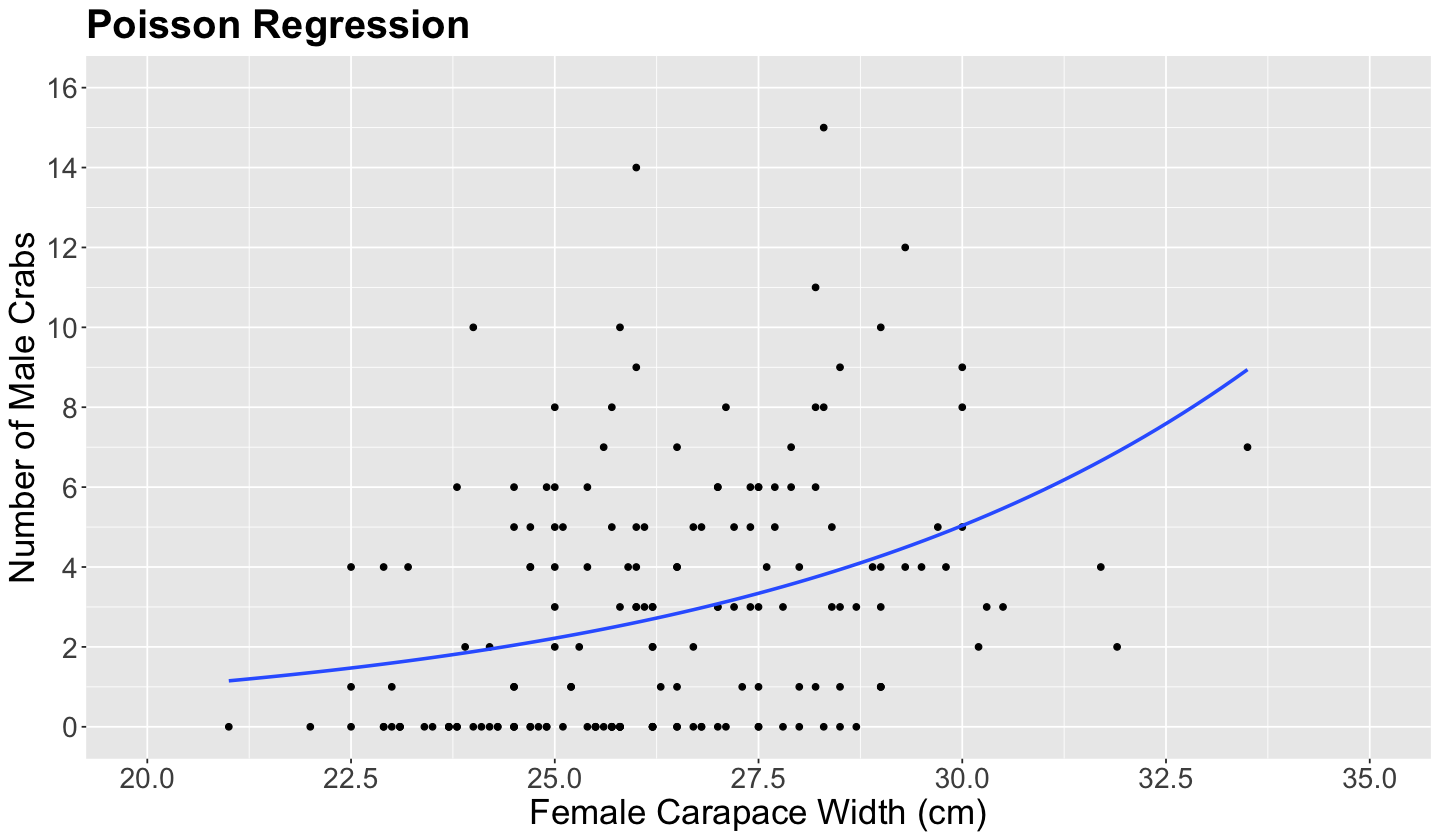

In [26]:
plot_crabs_vs_width <- plot_crabs_vs_width +
  geom_smooth(
    data = crabs, aes(width, n_males),
    method = "glm", formula = y ~ x,
    method.args = list(family = poisson), se = FALSE
  ) +
  ggtitle("Poisson Regression")
plot_crabs_vs_width

The blue line in the plot above is the fitted Poisson regression of `n_males` versus carapace `width`. **The positive relationship is now clear with this regression line.**

### 5.6. Coefficient Interpretation

Let us fit a second model with two regressors related to the female crab: carapace `width` ($X_{\texttt{width}_i}$) and `color` of the prosoma ($X_{\texttt{color_darker}_i}$, $X_{\texttt{color_light}_i}$, and $X_{\texttt{color_medium}_i}$) for the $i$th observation:

$$
h(\lambda_i) = \log (\lambda_i) = \beta_0 + \beta_1 X_{\texttt{width}_i} + \beta_2 X_{\texttt{color_darker}_i} + \beta_3 X_{\texttt{color_light}_i} + \beta_4 X_{\texttt{color_medium}_i}.
$$

The explanatory variable `color` is of **factor-type** (**discrete**) and **categorical**. Moreover, it has a baseline: `dark`. **We can check the baseline level, via `levels()`, which is on the left-hand side.**

In [27]:
levels(crabs$color)

[1] "dark"   "darker" "light"  "medium"

Using explanatory variables such as `color` involves using **dummy variables** shown in {numref}`dummy-var`, such as in Binary Logistic regression. For example, the explanatory variable `color` has four levels; thus, this Poisson regression model will incorporate three dummy variables: $X_{\texttt{color_darker}_i}$, $X_{\texttt{color_light}_i}$, and $X_{\texttt{color_medium}_i}$. Depending on the `color`, these dummy variables take on the following values:

- When `color` is `darker`, then $X_{\texttt{color_darker}_i} = 1$ while the other two dummy variables $X_{\texttt{color_light}_i} = X_{\texttt{color_medium}_i} = 0$.
- When `color` is `light`, then $X_{\texttt{color_light}_i} = 1$ while the other two dummy variables $X_{\texttt{color_darker}_i} = X_{\texttt{color_medium}_i} = 0$.
- When `color` is `medium`, then $X_{\texttt{color_medium}_i} = 1$ while the other two dummy variables $X_{\texttt{color_darker}_i} = X_{\texttt{color_light}_i} = 0$.

Note that the level `dark` is depicted as the baseline here. Hence, the interpretation of the coefficients in the model for each dummy variable will be to this baseline.

Now, let us fit this second Poisson regression model:

In [28]:
poisson_model_2 <- glm(n_males ~ width + color, family = poisson, data = crabs)
tidy(poisson_model_2, conf.int = TRUE) |>
  mutate_if(is.numeric, round, 3)

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-3.086,0.557,-5.536,0.000,-4.178,-1.993
width,0.149,0.021,7.166,0.000,0.108,0.190
colordarker,-0.011,0.180,-0.061,0.951,-0.373,0.336
colorlight,0.436,0.176,2.474,0.013,0.083,0.776
colormedium,0.237,0.118,2.003,0.045,0.009,0.473


We can see that `width`, `colorlight`, and `colormedium` are significant according to the `p.value` column (with $\alpha = 0.05$).

First, let us focus on the coefficient corresponding to female carapace `width`, **while keeping `color` of the prosoma constant**. Consider an observation with a given value $X_{\texttt{width}} = \texttt{w}$ cm, and another observation with a given $X_{\texttt{width + 1}} = \texttt{w} + 1$ cm (i.e., an increase of $1$ cm). Then we have their corresponding regression equations:

```{math}
\begin{gather*}
\log \left( \lambda_{\texttt{width}} \right) = \beta_0 + \beta_1 \overbrace{\texttt{w}}^{X_{\texttt{width}}} + \overbrace{\beta_2 X_{\texttt{color_darker}} + \beta_3 X_{\texttt{color_light}} + \beta_4 X_{\texttt{color_medium}}}^{\text{Constant}} \\
\log \left( \lambda_{\texttt{width + 1}} \right) = \beta_0 + \beta_1 \underbrace{(\texttt{w} + 1)}_{X_{\texttt{width + 1}}} + \underbrace{\beta_2 X_{\texttt{color_darker}} + \beta_3 X_{\texttt{color_light}} + \beta_4 X_{\texttt{color_medium}}.}_{\text{Constant}}
\end{gather*}
```

We take the difference between both equations as:

```{math}
\begin{align*}
\log \left( \lambda_{\texttt{width + 1}} \right) - \log \left( \lambda_{\texttt{width1}} \right) &= \beta_1 (\texttt{w} + 1) - \beta_1 \texttt{w} \\
&= \beta_1.
\end{align*}
```

We apply the logarithm property for a ratio:

```{math}
\begin{align*}
\log \left( \frac{\lambda_{\texttt{width + 1}} }{\lambda_{\texttt{width}}} \right) &= \log \left( \lambda_{\texttt{width + 1}} \right) - \log \left( \lambda_{\texttt{width}} \right) \\
&= \beta_1.
\end{align*}
```

Finally, we have to exponentiate the previous equation:

$$
\frac{\lambda_{\texttt{width + 1}} }{\lambda_{\texttt{width}}} = e^{\beta_1}.
$$

The expression $\frac{\lambda_{\texttt{width + 1}} }{\lambda_{\texttt{width}}} = e^{\beta_1}$ indicates that the response varies in a **multiplicative way** when increased 1 cm in carapace `width`.

Therefore, by using the estimate $\hat{\beta}_1$ (note the hat notation) coming from the model `poisson_model_2`, we calculate this multiplicative effect as follows (via `exponentiate = TRUE` in `tidy()`):

In [29]:
tidy(poisson_model_2, exponentiate = TRUE, conf.int = TRUE) |>
  mutate_if(is.numeric, round, 3)

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.046,0.557,-5.536,0.000,0.015,0.136
width,1.161,0.021,7.166,0.000,1.114,1.209
colordarker,0.989,0.180,-0.061,0.951,0.688,1.399
colorlight,1.547,0.176,2.474,0.013,1.087,2.174
colormedium,1.267,0.118,2.003,0.045,1.009,1.604


> $\frac{\hat{\lambda}_{\texttt{width + 1}} }{\hat{\lambda}_{\texttt{width}}} = e^{\hat{\beta}_1} = 1.16$ indicates that **the mean count of male crabs (`n_males`) around a female breeding nest** increases by $16\%$ when increasing the female carapace `width` by $1$ cm, **while keeping the female carapace `color` constant**. 

The interpretation of the significant coefficients corresponding to `color` (`colorlight` and `colormedium` with $\alpha = 0.05$) is associated to the baseline level `dark`.

Consider two observations, one with `dark` `color` of the prosoma (the baseline) and another with `light` `color`. Their corresponding responses are denoted as $\lambda_{\texttt{D}}$ (for `dark`) and $\lambda_{\texttt{L}}$ (for `light`). While holding $X_{\texttt{width}}$ constant, their regression equations are:

```{math}
\begin{gather*}
\log \left( \lambda_{\texttt{D}} \right) = \beta_0 + \overbrace{\beta_1 X_{\texttt{width}}}^{\text{Constant}} + \beta_2 X_{\texttt{color_darker}_{\texttt{D}}} + \beta_3 X_{\texttt{color_light}_{\texttt{D}}} + \beta_4 X_{\texttt{color_medium}_{\texttt{D}}} \\
\log \left( \lambda_{\texttt{L}} \right) = \beta_0 + \underbrace{\beta_1 X_{\texttt{width}}}_{\text{Constant}} + \beta_2 X_{\texttt{color_darker}_{\texttt{L}}} + \beta_3 X_{\texttt{color_light}_{\texttt{L}}} + \beta_4 X_{\texttt{color_medium}_{\texttt{L}}}
\end{gather*}
```

The corresponding `color` indicator variables for both $\lambda_{\texttt{D}}$ and $\lambda_{\texttt{L}}$ take on these values:

```{math}
\begin{align*}
\log \left( \lambda_{\texttt{D}} \right) &= \beta_0 + \overbrace{\beta_1 X_{\texttt{width}}}^{\text{Constant}} + \beta_2 X_{\texttt{color_darker}_{\texttt{D}}} + \beta_3 X_{\texttt{color_light}_{\texttt{D}}} + \beta_4 X_{\texttt{color_medium}_{\texttt{D}}} \\
&= \beta_0 + \beta_1 X_{\texttt{width}}+ \beta_2 \times 0 + \beta_3 \times 0 + \beta_4 \times 0 \\
&= \beta_0 + \beta_1 X_{\texttt{width}}
\end{align*}
```

```{math}
\begin{align*}
\log \left( \lambda_{\texttt{L}} \right) &= \beta_0 + \beta_1 X_{\texttt{width}} + \beta_2 X_{\texttt{color_darker}_{\texttt{L}}} + \beta_3 X_{\texttt{color_light}_{\texttt{L}}} + \beta_4 X_{\texttt{color_medium}_{\texttt{L}}} \\
&= \beta_0 + \beta_1 X_{\texttt{width}}+ \beta_2 \times 0 + \beta_3 \times 1 + \beta_4 \times 0 \\
&= \beta_0 + \underbrace{\beta_1 X_{\texttt{width}}}_{\text{Constant}} + \beta_3.
\end{align*}
```

Therefore, **what is the association of the level `light` with respect to `dark`?** Let us take the differences again:

```{math}
\begin{align*}
\log \left( \frac{\lambda_{\texttt{L}} }{\lambda_{\texttt{D}}} \right) &= \log \left( \lambda_{\texttt{L}} \right) - \log \left( \lambda_{\texttt{D}} \right) \\
&= \beta_3.
\end{align*}
```

Then, we exponentiate the previous equation:

$$
\frac{\lambda_{\texttt{L}} }{\lambda_{\texttt{D}}} = e^{\beta_3}.
$$

The expression $\frac{\lambda_{\texttt{L}} }{\lambda_{\texttt{D}}} = e^{\beta_3}$ indicates that the response varies in a **multiplicative way** when the `color` of the prosoma changes from `dark` to `light`.

Therefore, by using the estimate $\hat{\beta}_3$ (note the hat notation) coming from the model `poisson_model_2`, we calculate this multiplicative effect as follows (via `exponentiate = TRUE` in `tidy()`):

In [30]:
tidy(poisson_model_2, exponentiate = TRUE, conf.int = TRUE) |>
  mutate_if(is.numeric, round, 3)

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.046,0.557,-5.536,0.000,0.015,0.136
width,1.161,0.021,7.166,0.000,1.114,1.209
colordarker,0.989,0.180,-0.061,0.951,0.688,1.399
colorlight,1.547,0.176,2.474,0.013,1.087,2.174
colormedium,1.267,0.118,2.003,0.045,1.009,1.604


> $\frac{\hat{\lambda}_{\texttt{L}} }{\hat{\lambda}_{\texttt{D}}} = e^{\hat{\beta}_3} = 1.547$ indicates that **the mean count of male crabs (`n_males`) around a female breeding nest** increases by $54.7\%$ when the female `color` of the prosoma changes from `dark` to `light`, **while keeping the carapace female `width` constant**.

### 5.7. Predictions

Suppose we want to predict **the mean count of male crabs (`n_males`) around a female breeding nest** with a female carapace `width` of $27.5$ cm and `light` `color` of the female prosoma. We could use the model `poisson_model_2` for making such prediction as follows:

In [31]:
round(predict(poisson_model_2, newdata = tibble(width = 27.5, color = "light"),
  type = "response"), 2)

1 
4.29

Note we have to use `type = "response"` in the function `predict()` to obtain the prediction **on its original scale**.

## 6. Overdispersion

From [**DSCI 551**](https://ubc-mds.github.io/DSCI_551_stat-prob-dsci/notes/appendix-dist-cheatsheet.html#), we know that population variances of some random variables are **in function** of their respective means. For instance:

- If $X \sim \text{Exponential}(\lambda)$, then $\mathbb{E}(X) = \lambda$ and $\text{Var}(X) = \lambda^2$.
- If $X \sim \text{Binomial}(n , p)$, then $\mathbb{E}(X) = n p$ and $\text{Var}(X) = n p (1 - p)$.
- If $X \sim \text{Poisson}(\lambda)$, then $\mathbb{E}(X) = \lambda$ and $\text{Var}(X) = \lambda$.

Now, you might wonder:

> How does equidispersion affect our Poisson regression model?

First, we must clarify that GLMs naturally deal with some types of **heteroscedasticity** (inequality of variances across the responses). For example, note that each observation $i = 1, \dots, n$ in our training set (used to estimate a Poisson regression model) is assumed as:

$$Y_i \sim \text{Poisson}(\lambda_i),$$

where the indexed parameter $\lambda_i$ makes the model flexible enough to deal with heteroscedasticity. Moreover, the larger $\lambda_i$ is, the larger the variance per observation will be.

Let us make a quick simulation on this matter. The code below creates ten samples of $n = 1000$ each from different Poisson populations with an increasing variance $\lambda$.

In [32]:
set.seed(562)

poisson_samples <- tibble(x = -1, lambda = 0)

for (lambda in seq(1, 91, 10)) {
  sample <- rpois(1000, lambda)
  poisson_samples <- poisson_samples |> bind_rows(tibble(
    x = sample,
    lambda = lambda
  ))
}

poisson_samples <- poisson_samples |> 
  filter(x != -1)

The side-by-side jitter plots below illustrate the impact of an increasing variance in each of the ten Poisson populations, where each set of $n = 1000$ data points gets more and more spread out. We see the same trend with the side-by-side boxplots.

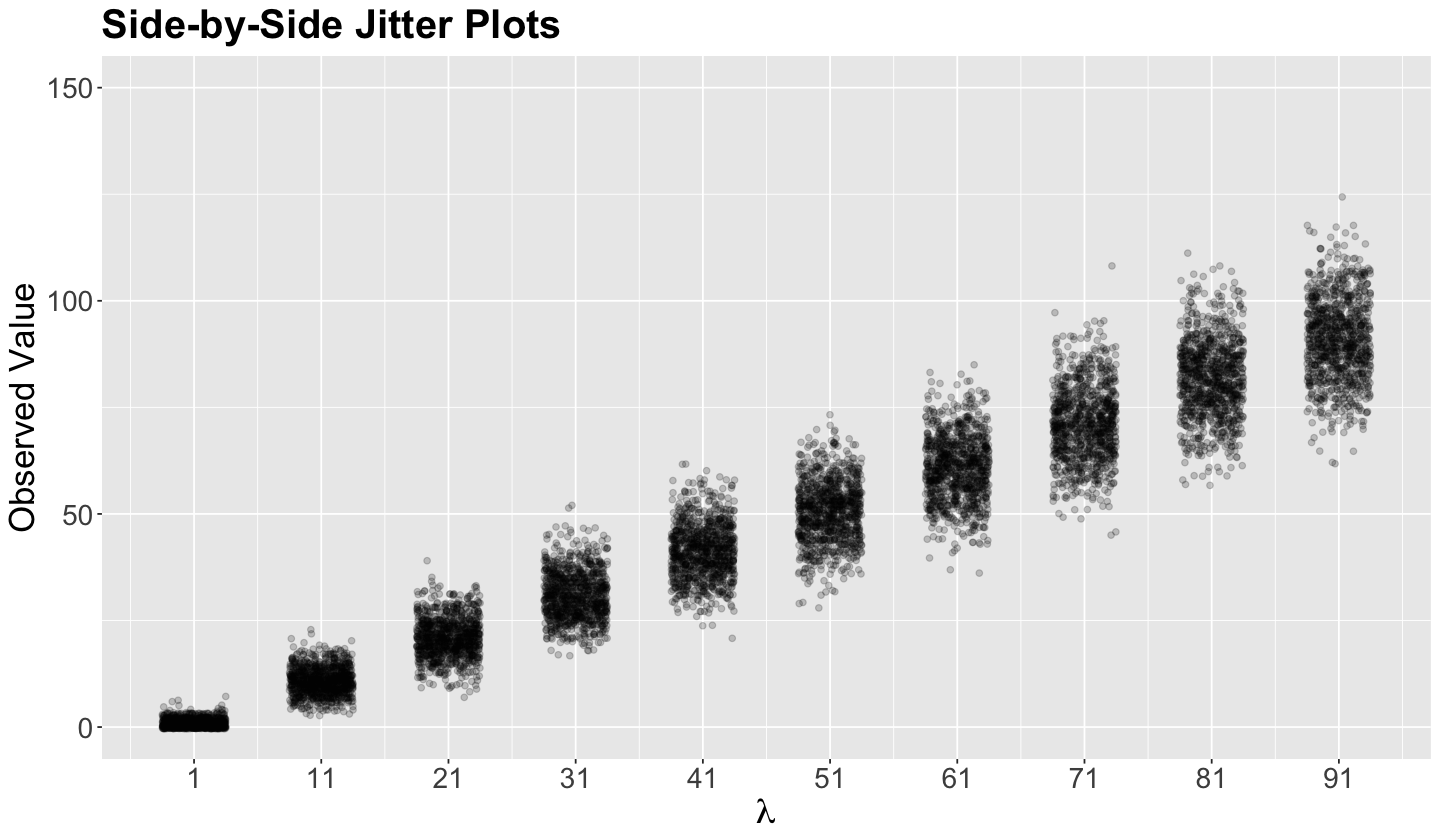

In [33]:
poisson_jitter_plots <- poisson_samples |>
  ggplot(aes(lambda, x)) +
  geom_jitter(alpha = .2, width = 2.5) +
  theme(
    plot.title = element_text(size = 24, face = "bold"),
    axis.text = element_text(size = 17),
    axis.title = element_text(size = 21)
  ) +
  coord_cartesian(ylim = c(0, 150)) +
  labs(y = "Observed Value") +
  ggtitle("Side-by-Side Jitter Plots") +
  scale_x_continuous(breaks = seq(1, 91, 10)) + 
  labs(x = expression(lambda))
poisson_jitter_plots

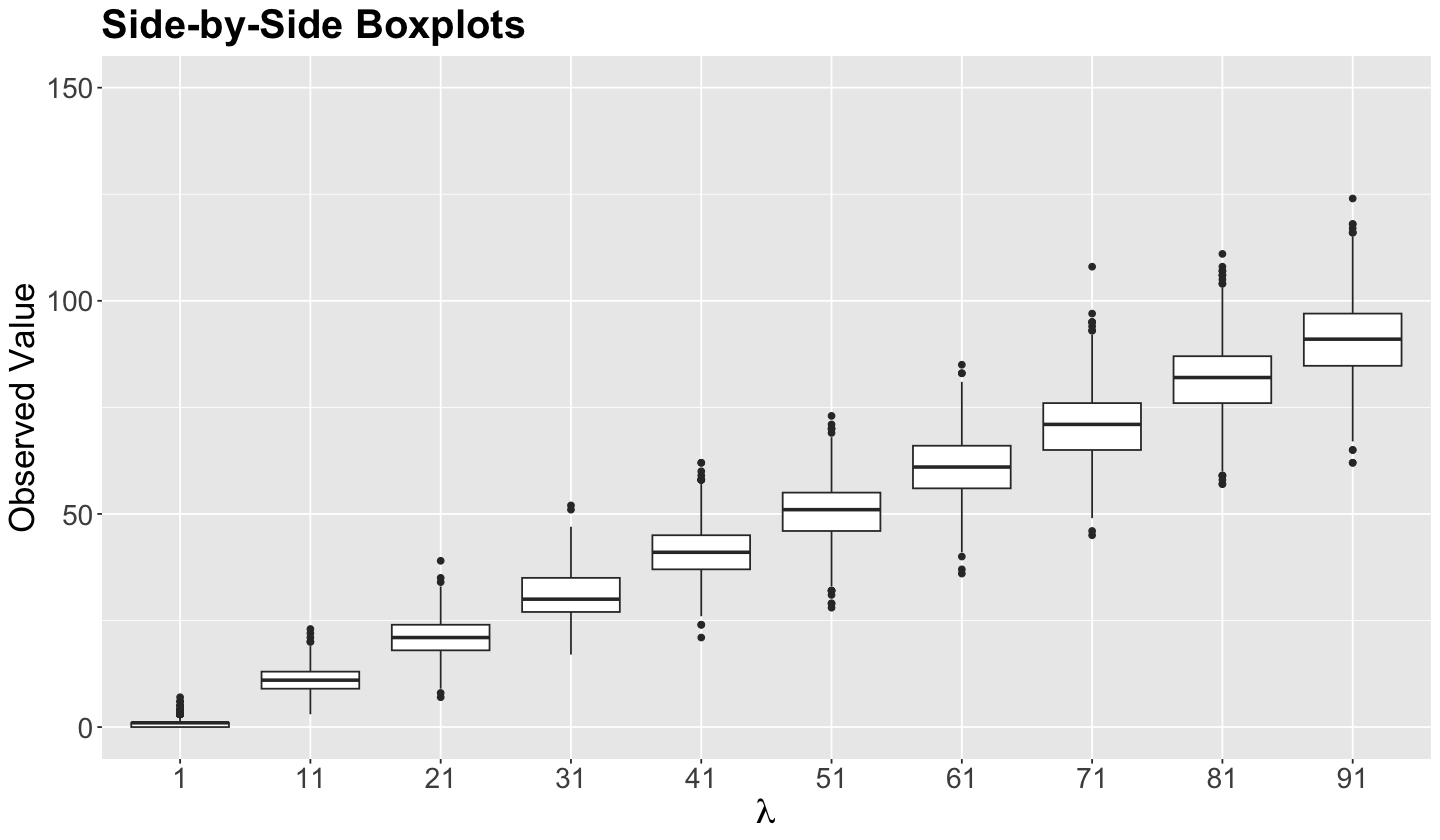

In [34]:
poisson_boxplots <- poisson_samples |>
  ggplot(aes(x = as_factor(lambda), y = x)) + 
  geom_boxplot() +
  theme(
    plot.title = element_text(size = 24, face = "bold"),
    axis.text = element_text(size = 17),
    axis.title = element_text(size = 21)
  ) +
  coord_cartesian(ylim = c(0, 150)) +
  labs(y = "Observed Value", x = "lambda") +
  ggtitle("Side-by-Side Boxplots") + 
  labs(x = expression(lambda))
poisson_boxplots

```{important} 
We already defined **equidispersion** as an important characteristic of a Poisson random variable. 

Furthermore, theoretically, we already pointed out that this random variable has the same mean and variance. The mean is the average of values in our dataset. 

Variance measures how spread the data is. It is computed as the average of the squared differences from the mean. A variance will be equal to zero if all values in our dataset are identical. The greater the difference between the values, the greater the variance.
```

From the below plot, note that the relationship of the **sample variance** in these samples is practically linear to the population $\lambda$. So this is what equidispersion graphically looks like.

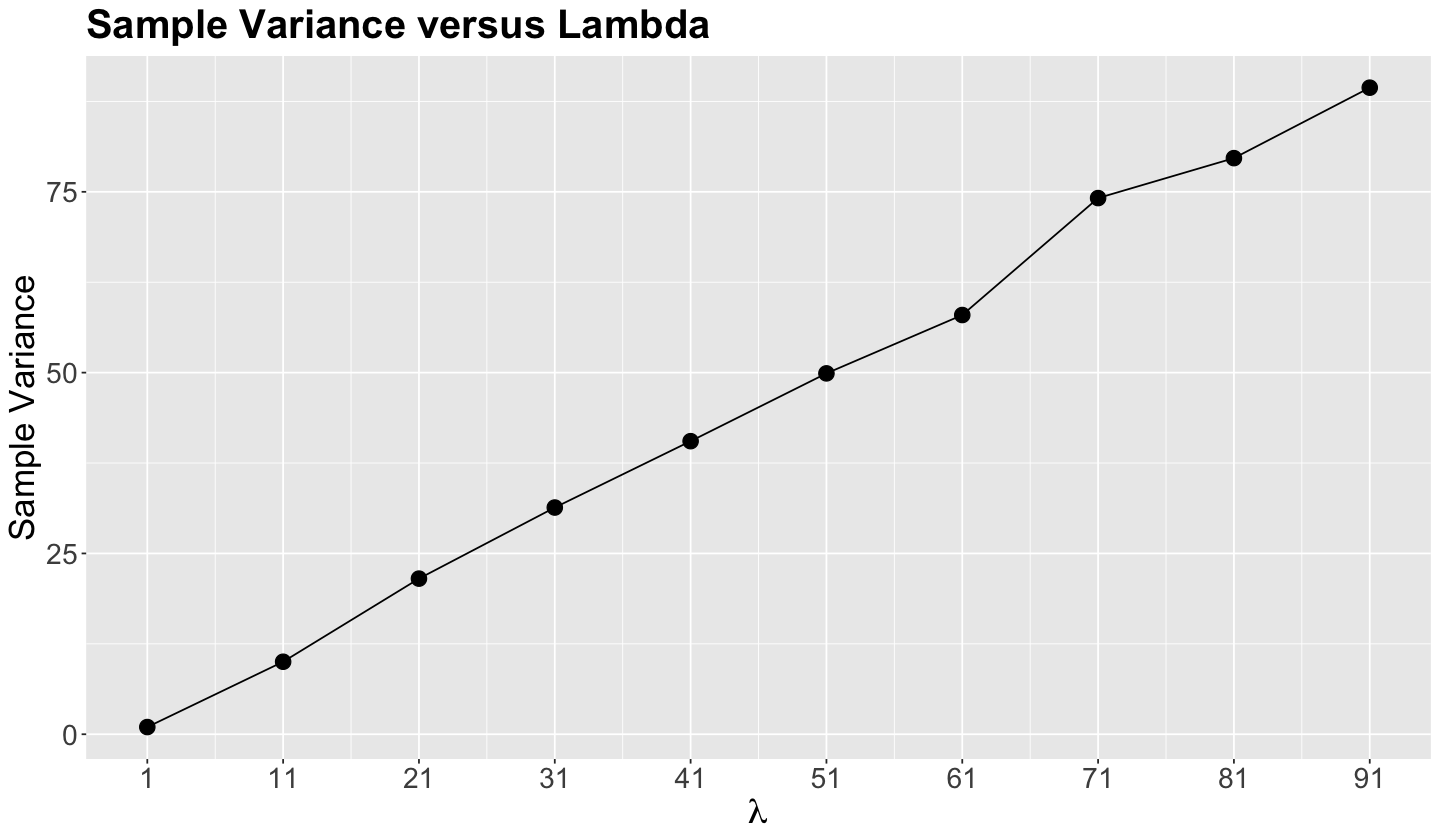

In [35]:
suppressWarnings(suppressMessages(print(poisson_samples |>
  group_by(lambda) |>
  summarise(sample_variance = var(x)) |>
  ggplot() +
  geom_line(aes(lambda, sample_variance)) +
  geom_point(aes(lambda, sample_variance), size = 4) +
  theme(
    plot.title = element_text(size = 24, face = "bold"),
    axis.text = element_text(size = 17),
    axis.title = element_text(size = 21)
  ) +
  labs(y = "Sample Variance", x = expression(lambda)) +
  ggtitle("Sample Variance versus Lambda") +
  scale_x_continuous(breaks = seq(1, 91, 10)))))

Having said all this, in many cases, the variance of our data is sometimes larger than the variance considered by our model **as in the basic Poisson regression**.

```{admonition} Definition of Overdispersion
:class: tip
When the variance is larger than the mean in a random variable, we have **overdispersion**. This matter will impact the standard error of our parameter estimates in a basic Poisson regression, as we will see.
```

Let us go back to our `poisson_model_2` with the log link function from the `crabs` dataset with two regressors on the female crab: carapace `width` ($X_{\texttt{width}_i}$) and `color` of the prosoma ($X_{\texttt{color_darker}_i}$, $X_{\texttt{color_light}_i}$, and $X_{\texttt{color_medium}_i}$) for the $i$th observation:

$$
h(\lambda_i) = \log (\lambda_i) = \beta_0 + \beta_1 X_{\texttt{width}_i} + \beta_2 X_{\texttt{color_darker}_i} + \beta_3 X_{\texttt{color_light}_i} + \beta_4 X_{\texttt{color_medium}_i}.
$$

In [36]:
summary(poisson_model_2)


Call:
glm(formula = n_males ~ width + color, family = poisson, data = crabs)

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -3.08640    0.55750  -5.536 3.09e-08 ***
width        0.14934    0.02084   7.166 7.73e-13 ***
colordarker -0.01100    0.18041  -0.061   0.9514    
colorlight   0.43636    0.17636   2.474   0.0133 *  
colormedium  0.23668    0.11815   2.003   0.0452 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 632.79  on 172  degrees of freedom
Residual deviance: 559.34  on 168  degrees of freedom
AIC: 924.64

Number of Fisher Scoring iterations: 6


We will test whether there is overdispersion in this Poisson regression model via function `dispersiontest()` (from package `AER`). 

Let $Y_i$ be the $i$th Poisson response in the count regression model. **Ideally in the presence of equidispersion**, $Y_i$ has the following parameters:

```{math}
\begin{gather*}
\mathbb{E}(Y_i) = \lambda_i \\
\text{Var}(Y_i) = \lambda_i.
\end{gather*}
```

The test uses the following mathematical expression:

$$
\text{Var}(Y_i) = \overbrace{(1 + \gamma)}^\text{Dispersion Factor} \lambda_i,
$$

with the hypotheses

```{math}
\begin{gather*}
H_0: 1 + \gamma = 1 \\
H_a: 1 + \gamma > 1.
\end{gather*}
```

When there is evidence of overdispersion in our data, **we will reject $H_0$**.

In [37]:
dispersiontest(poisson_model_2)


	Overdispersion test

data:  poisson_model_2
z = 5.3255, p-value = 5.033e-08
alternative hypothesis: true dispersion is greater than 1
sample estimates:
dispersion 
  3.154127 


With $\alpha = 0.05$, we reject $H_0$ since the $p\text{-value} < .001$. Hence, the `poisson_model_2` has overdispersion.

## 7. Negative Binomial Regression

Let

$$Y_i \sim \text{Negative Binomial} (m, p_i) \quad \text{for} \quad i = 1, \dots, n.$$

From **DSCI 551**, recall that a Negative Binomial distribution has the following probability mass function (PMF):

```{math}
:label: nb-pdf
\begin{equation}
P(Y_i = y_i \mid m, p_i) = {m - 1 + y_i \choose y_i} p_i^{m} (1 - p_i)^{y_i} \quad \text{for} \quad y_i = 0, 1, \dots
\end{equation}
```

A Negative Binomial random variable depicts **the number of $y_i$ failed independent Bernoulli trials before experiencing $m$ successes** with a probability of success $p_i$.

This distribution has the following mean and variance:

```{math}
\begin{gather*}
\mathbb{E}(Y_i) = \frac{m(1 - p_i)}{p_i} \\
\text{Var}(Y_i) = \frac{m(1 - p_i)}{p_i^2}.
\end{gather*}
```

### 7.1. Reparametrization 

Under the following parametrization:

```{math}
:label: nb-param
\begin{equation}
\lambda_i = \frac{m (1 - p_i)}{p_i} \qquad \Rightarrow \qquad p_i = \frac{m}{m + \lambda_i},
\end{equation}
```

the mean and variance of a Negative Binomial random variable can be reexpressed as

```{math}
:label: nb-mean-variance
\begin{gather}
\mathbb{E}(Y_i) = \lambda_i \\
\text{Var}(Y_i) = \lambda_i \left( 1 + \frac{\lambda_i}{m} \right).
\end{gather}
```

This reparametrized variance indicates that a Negative Binomial random variable allows for overdispersion through factor $\left( 1 + \frac{\lambda_i}{m} \right)$.

Finally, by applying parametrization {eq}`nb-param` in PMF {eq}`nb-pdf`, we have the following:

```{math}
:label: nb-alt-pdf
\begin{align}
P(Y_i = y_i \mid m, p_i) &= {m - 1 + y_i \choose y_i} p_i^{m} (1 - p_i)^{y_i} \\
&= \frac{(m + y_i - 1)!}{y_i! (m - 1 )!} \left( \frac{m}{m + \lambda} \right)^{m} \left( 1 - \frac{m}{m + \lambda} \right)^{y_i} \\
&= \frac{\Gamma(y_i + m)}{\Gamma(y_i + 1) \Gamma(m)} \left( \frac{m}{m + \lambda} \right)^{m} \left( 1 - \frac{m}{m + \lambda} \right)^{y_i},
\end{align}
```

where $\Gamma(\cdot)$ is the [**Gamma function**](https://www.statlect.com/mathematical-tools/gamma-function). We actually use the property 

$$\Gamma(a) = (a - 1)!,$$ 

where $a \geq 1$ is an integer.

```{admonition} Note
:class: note
In **DSCI 551**, we highlighted the fact that some distributions converge to anothers where certain parameters tend to infinity. It can be shown that

$$X \sim \text{Poisson}(\lambda) = \lim_{m \to \infty} \text{Negative Binomial}(m, p).$$

**The proof is out of the scope of this course.**
```

### 7.2. Data Modelling Framework

As in the case of Poisson regression with $k$ regressors, the Negative Binomial case is a GLM with the following link function:

```{math}
:label: nb-model
\begin{equation}
h(\lambda_i) = \log(\lambda_i) = \beta_0 + \beta_1 X_{i,1} + \dots + \beta_k X_{i,k}.
\end{equation}
```
Lastly, note the following: 

- From {eq}`nb-mean-variance`, let $\theta = \frac{1}{m}$. Then, Negative Binomial regression will assume the following variance:

```{math}
\begin{align*}
\text{Var}(Y_i) &= \lambda_i \left( 1 + \frac{\lambda_i}{m} \right) \\
&= \lambda_i + \frac{\lambda_i^2}{m} \\
&= \lambda_i + \theta \lambda_i^2.
\end{align*}
```

```{important} 
Therefore, the model has even more flexibility to deal with overdispersion compared to Poisson regression.
```

### 7.3. Estimation

Via a training set of size $n$ whose responses are **independent counts** $Y_i$ ($i = 1, \dots, n$), we use the reparametrized PMF {eq}`nb-alt-pdf` along with the link function {eq}`nb-model` via **maximum likelihood estimation** to obtain $\hat{\beta}_0, \hat{\beta}_1, \dots, \hat{\beta}_k, \hat{\theta}$.
  
To fit a Negative Binomial regression via `R`, we can use the function `glm.nb()` from package `MASS`.

In [38]:
library(MASS)


Attaching package: ‘MASS’


The following object is masked _by_ ‘.GlobalEnv’:

    crabs


The following object is masked from ‘package:dplyr’:

    select




In [39]:
negative_binomial_model <- glm.nb(n_males ~ width + color, data = crabs)
summary(negative_binomial_model)


Call:
glm.nb(formula = n_males ~ width + color, data = crabs, init.theta = 0.9320986132, 
    link = log)

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -3.87271    1.19047  -3.253  0.00114 ** 
width        0.17839    0.04529   3.939 8.18e-05 ***
colordarker -0.01570    0.33125  -0.047  0.96220    
colorlight   0.52033    0.38396   1.355  0.17536    
colormedium  0.24440    0.22864   1.069  0.28510    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Negative Binomial(0.9321) family taken to be 1)

    Null deviance: 216.56  on 172  degrees of freedom
Residual deviance: 196.23  on 168  degrees of freedom
AIC: 760.6

Number of Fisher Scoring iterations: 1


              Theta:  0.932 
          Std. Err.:  0.168 

 2 x log-likelihood:  -748.596 

Note that the output provides $\hat{\theta} = 0.932$ along with its standard error $\text{se} \left( \hat{\theta} \right) = 0.168$. Moreover, the standard errors of the other estimates are larger than in `poisson_model_2` (check the below summary). 

In [40]:
summary(poisson_model_2)


Call:
glm(formula = n_males ~ width + color, family = poisson, data = crabs)

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -3.08640    0.55750  -5.536 3.09e-08 ***
width        0.14934    0.02084   7.166 7.73e-13 ***
colordarker -0.01100    0.18041  -0.061   0.9514    
colorlight   0.43636    0.17636   2.474   0.0133 *  
colormedium  0.23668    0.11815   2.003   0.0452 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 632.79  on 172  degrees of freedom
Residual deviance: 559.34  on 168  degrees of freedom
AIC: 924.64

Number of Fisher Scoring iterations: 6


```{exercise}
:label: lecture1-q3

Under the context of this crab problem with overdispersion as assessed by the **overdispersion test**, suppose we use `poisson_model_2` to perform inference on the response and regressors. 

What is the consequence of using these **underestimated** standard errors compared to the ones from `negative_binomial_model`?

**A.** We are more prone to commit Type I errors (i.e., rejecting $H_a$ when in fact it is true).

**B.** We are more prone to commit Type I errors (i.e., rejecting $H_0$ when in fact it is true).

**C.** We are more prone to commit Type II errors (i.e., rejecting $H_a$ when in fact it is true).

**D.** We are more prone to commit Type II errors (i.e., rejecting $H_0$ when in fact it is true).
```

### 7.4. Inference, Coefficient Interpretation, Prediction, Goodness of Fit, and Model Selection

Since the link function in Negative Binomial regression is the same as in Poisson regression; **inference, coefficient interpretation, and prediction are performed similarly** (even with the same `broom` functions!). Regarding **model selection**, since we use a regular maximum likelihood approach to estimate the regression parameters, we can use analysis of deviance, AIC, and BIC to perform model selection and/or goodness of fit testing.

## 8. Wrapping Up on Count Regression Models

- Poisson regression is the most basic regression approach for a count-type response. We have to be cautious about this model since it assumes equidispersion. 
- Negative Binomial regression is more flexible than the Poisson case since the variance's representation allows it to be a quadratic function of the mean with an additional parameter. 
- As we can see, the Negative Binomial regression model has extra parameters in the variance expression that allow us to construct a more accurate model for specific count data (since the mean and the variance do not need to be assumed as equal!). However, the variable association tests and conclusions are conducted similarly under these two models, as in the Poisson regression.